# DTSA-5509 Supervised Learning Final Project

- Exploring the UCI Heart Disease dataset 
- Identifying notable characteristics
- Predicting Heart Disease

## Objective and Motivation

The goal of this project is to predict the occurrence of heart disease in individuals based on a set of features related to their health and lifestyle. This project involves understanding the key factors that contribute to heart disease, which can be beneficial for healthcare professionals in early diagnosis and potential prevention.

We will explore the dataset, train a collection of classifiers, and compare model performances and results.

## Github

Screen recording with narration to be uploaded to the follwing repo:

<a href="https://github.com/wahargis/DTSA-5509_Final_Project" target="_new">https://github.com/wahargis/DTSA-5509_Final_Project</a>

## Library Imports

In [115]:
#libraries for parallelization
import dask_ml.model_selection
import dask_ml.metrics as dd_metric
from dask.distributed import Client, LocalCluster

# Create a local cluster with 2 workers, each using 4 threads
cluster = LocalCluster(n_workers=12, threads_per_worker=2)
client = Client(cluster)

import optuna
from numba import jit
from joblib import parallel_backend, effective_n_jobs
#import modin.pandas as pd
import dask.dataframe as dd
from dask import config
import dask_ml.model_selection as dcv  # for Dask's cross-validation
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [116]:
# libraries for file manipulation and warning handling
import os
import time
import logging
import warnings
from tqdm import tqdm
from joblib import dump, load
import gc

# Libraries for data handling
import math
import numpy as np
import pandas as pd
from collections import Counter
import requests
import random

#imports for model training and validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
#Recursive Feature Elimination
from sklearn.feature_selection import RFE 

#imports for preprocessing our data
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#imports for our classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost.dask import DaskXGBClassifier as XGBClassifier
warnings.filterwarnings('ignore', 'Windows is not officially supported for dask/xgboost, contribution are welcomed.')
#imports for plotting
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
%matplotlib inline

#imports for attractive printing of dataframes
from IPython.display import display

# Exploratory Data Analysis

## Set Up Data Pull

In [117]:
def get_heart_disease_data(
    dataset='cleveland',
    header=None,
    sep=',',
    fill_na_values=["?"],
    extract_folder = os.getcwd(),
    print_license=False,
    print_institution=False,
    verbose=False,
    local=False,
    license_only = False
):
    # Dictionary for dataset properties
    url_switcher = {
        'cleveland': {
            'url': "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
            'local_path': os.path.join(extract_folder,"/data/", "processed.cleveland.data"),
            'column_names': ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"],
            'sep': ',',
            'institution': 'Cleveland Clinic Foundation, Cleveland, OH, US'
        },
        'hungary': {
            'url': "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
            'local_path': os.path.join(extract_folder,"/data/", "processed.hungarian.data"),
            'column_names': ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"],
            'sep': ',',
            'institution': 'Hungarian Institute of Cardiology, Budapest, Hungary'
        },
        'switzerland': {
            'url': "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
            'local_path': os.path.join(extract_folder,"/data/", "processed.switzerland.data"),
            'column_names': ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"],
            'sep': ',',
            'institution': 'University Hospital, Zurich, Switzerland'
        },
        'veterans_affairs': {
            'url': "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
            'local_path': os.path.join(extract_folder,"/data/", "processed.va.data"),
            'column_names': ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"],
            'sep': ',',
            'institution': 'V.A. Medical Center, Long Beach, CA, US'
        }
    }

    # Create data folder if it doesn't exist
    data_folder_path = os.path.join(extract_folder, "data")
    if not os.path.exists(data_folder_path):
        os.makedirs(data_folder_path)

    # Use local path if local flag is set
    path = url_switcher[dataset]['local_path'] if local else url_switcher[dataset]['url']
    
    if not local:
        # Separate directory and file name from the local_path
        local_dir = os.path.dirname(url_switcher[dataset]['local_path'])
        local_file = os.path.basename(url_switcher[dataset]['local_path'])
        
        # Create the directory if it doesn't exist
        os.makedirs(local_dir, exist_ok=True)
        
        # Download and write the file
        response = requests.get(path)
        with open(os.path.join(local_dir, local_file), 'wb') as file:
            file.write(response.content)
            print(f'{dataset} written to {os.path.normpath(os.path.abspath(os.path.join(local_dir, local_file)))}')
        
        path = os.path.join(local_dir, local_file)

    # Read data
    data = pd.read_csv(
        path,
        header=header,
        names=url_switcher[dataset]['column_names'],
        na_values=fill_na_values,
        sep=url_switcher[dataset]['sep']
    )

    # Verbose output
    if verbose:
        display(data.head())
        print("Data shape : {}".format(data.shape))

    # Print license and institution details
    if print_license and not license_only:
        print("\nThis dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.\n")
        print(
            """\nJanosi, Andras; Steinbrunn, William; Pfisterer, Matthias; and Detrano, Robert. (1988). 
            Heart Disease. UCI Machine Learning Repository. 
            https://doi.org/10.24432/C52P4X.\n"""
        )

    if print_institution or verbose:
        print(url_switcher[dataset]['institution'])

    # Add institution column
    data['institution'] = url_switcher[dataset]['institution']
    
    if license_only and print_license:
        print("\nThis dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.\n")
        print(
            """\nJanosi, Andras; Steinbrunn, William; Pfisterer, Matthias; and Detrano, Robert. (1988). 
            Heart Disease. UCI Machine Learning Repository. 
            https://doi.org/10.24432/C52P4X.\n"""
        )
        return
    
    else:
        return data

In [118]:
def pull_grouped_hd_data(
    default_print = True,
    print_license=False,
    print_institution=False,
    verbose=False,
    local=False,
    license_only = False
):
    # Pulling data using the improved function
    get_heart_disease_data(print_license=print_license, license_only=license_only, local=local)

    datasets_to_pull = ['cleveland', 'hungary', 'switzerland', 'veterans_affairs']
    data = pd.concat([get_heart_disease_data(dataset, local=local) for dataset in datasets_to_pull], ignore_index=True)

    #Encode Institution to Numeric
    data_columns = data.columns
    enc = LabelEncoder().fit([col for i, col in enumerate(data['institution'].unique())])
    data['institution'] = enc.transform(data['institution'])
    data.columns = data_columns
    
    if default_print:
        display(data.head())
        print(data.shape)
    
    return data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'institution', 'target']]

In [119]:
data = pull_grouped_hd_data(print_license=True, license_only=True, local=False)

cleveland written to C:\data\processed.cleveland.data

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.


Janosi, Andras; Steinbrunn, William; Pfisterer, Matthias; and Detrano, Robert. (1988). 
            Heart Disease. UCI Machine Learning Repository. 
            https://doi.org/10.24432/C52P4X.

cleveland written to C:\data\processed.cleveland.data
hungary written to C:\data\processed.hungarian.data
switzerland written to C:\data\processed.switzerland.data
veterans_affairs written to C:\data\processed.va.data


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,institution
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


(920, 15)


## Dataset Description

- The UCI Heart Disease dataset is a dataset of health characteristics for 303 patients taken form the Cleveland Health Clinic.

- The dataset consists of 14 features (13 input_features | 1 target_feature) of patient health characteristics.

**input_features :**

| input_feature | datatype    | feature_description                                                      | Range of Values                                                            |
|---------------|-------------|--------------------------------------------------------------------------|:----------------------------------------------------------------------------|
| age           | Integer     | Age of patient in years                                                  | -                                                                          |
| sex           | Categorical | Sex of patient                                                           | {1 : male, 0 : female}                                                      |
| cp            | Categorical | Chest pain type                                                          | {1: typical anginal, 2: atypical anginal, 3: non-anginal pain, 4: asymptomatic} |
| trestbps      | Integer     | Resting blood pressure (in mm Hg on admission to the hospital)           | -                                                                          |
| chol          | Integer     | Serum cholestoral in mg/dl                                               | -                                                                          |
| fbs           | Categorical | Fasting blood sugar > 120 mg/dl                                          | {1: fbs > 120 mg/dl, 0 : fbs <= 120 mg/dl}                                                                     |
| restecg       | Categorical | Resting electrocardiographic results                                     | {0 : Normal, 1 : ST-T wave abnormality, 2 : left ventricular hypertrophy}   |
| thalach       | Integer     | Maximum heart rate achieved in beats per minute                          | -                                                                          |
| exang         | Categorical | Exercise induced angina (chest pain from restricted blood flow)                                     | {1: yes, 0 : no}                                                            |
| oldpeak       | Integer     | ST depression induced by exercise relative to rest                       | -                                                                          |
| slope         | Categorical | Slope of the peak exercise ST segment                                    | {1 : upsloping, 2: flat, 3 : downsloping}                                   |
| ca            | Integer     | Number of major vessels (0-3) colored by flourosopy                      | 0 to 3                                                                     |
| thal          | Categorical | Thalassemia, an inherited blood disorder                                 | {3 = normal; 6 = fixed defect; 7 = reversable defect} |                      |
| institution   | Categorical | Originating institution for the patient data                             | {0: Cleveland Clinic, 1: Hungarian Inst. of Cardiology, 2: University Hospital, Zurich, 3: V.A. Med. Center} |

**target_feature :**

| target_feature | datatype | feature_description | Range of values |
|---------|---------|---------|:---------|
| target | Integer | Diagnosis of heart disease | 0: Absence of heart disease |
|  |  |  | 1: Mild heart disease |
|  |  |  | 2: Moderate heart disease |
|  |  |  | 3: Severe heart disease |
|  |  |  | 4: Most severe heart disease |

## Continuous Feature Distribution

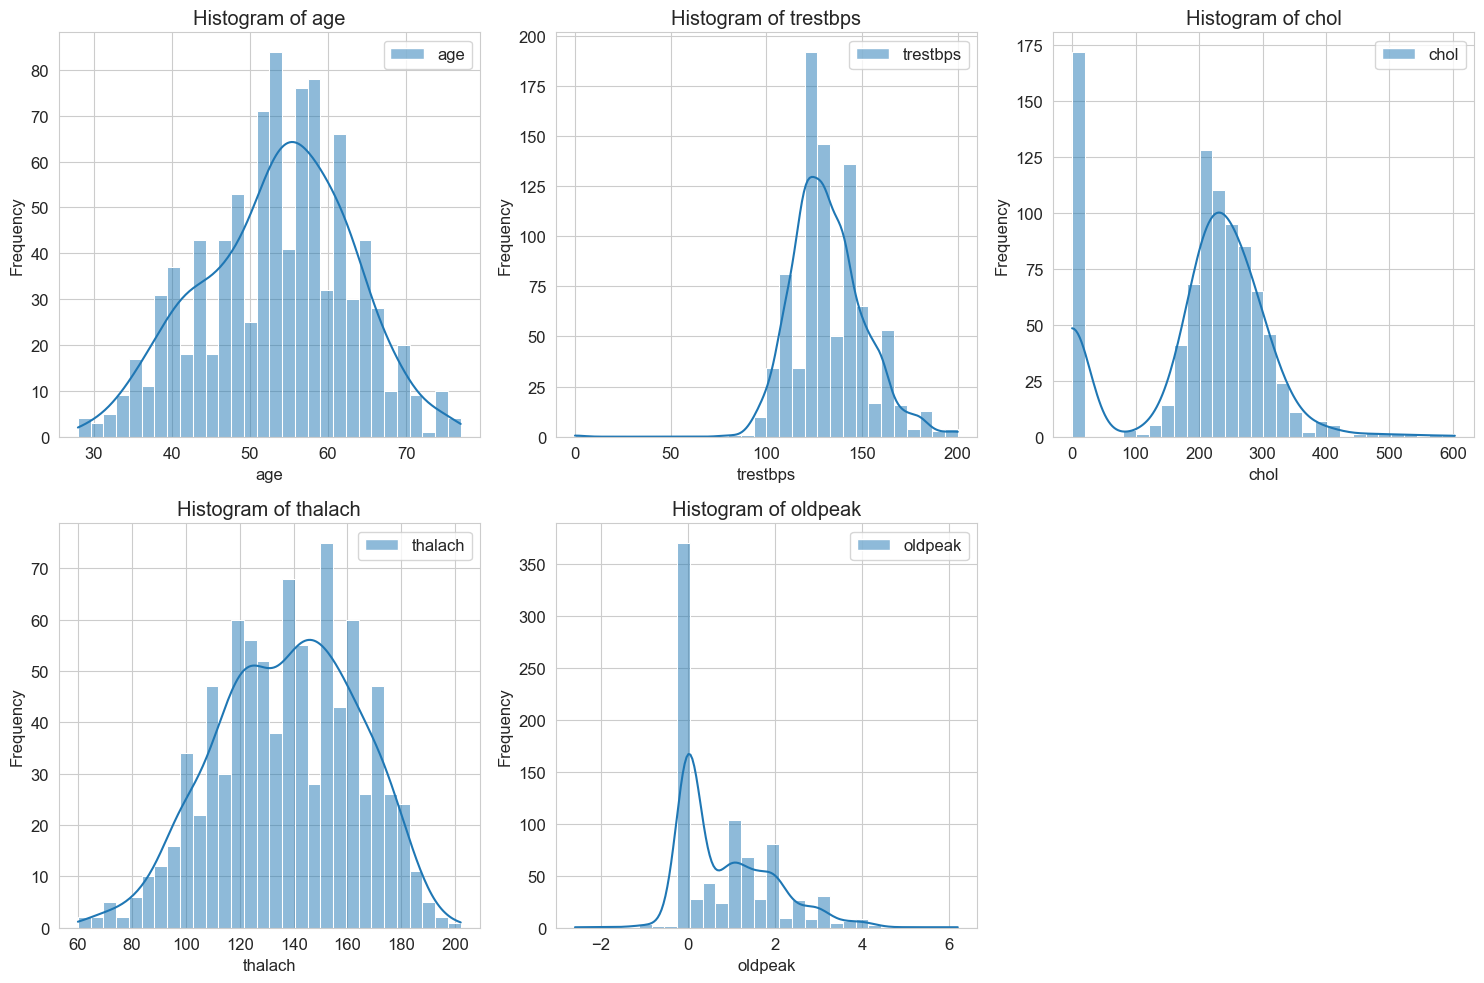

In [120]:
# Setting up the aesthetic parameters of Seaborn
sns.set_style("whitegrid")

# Continuous features for visualization
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Plotting histograms
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[[feature]], bins=30, kde=True, color='skyblue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.show()

# Notes on Continuous Features

- age: Most individuals in the dataset are in the age range of 50-65 years.

- trestbps (Resting Blood Pressure): The majority of individuals have a resting blood pressure in the range of 120-140 mm Hg. There appears to be an outlier at 0.0 which should be an erroneous value.

- chol (Serum Cholestrol): Most individuals have serum cholesterol levels in the range of 200-300 mg/dl. There appear to be extreme outliers as well as 0 values - this is likely unfilled data and will need to be examined.

- thalach (Maximum Heart Rate Achieved): A significant number of individuals have their maximum heart rate between 140 and 170 bpm. Some outliers on the low end.

- oldpeak (ST Depression Induced by Exercise Relative to Rest): Most values are clustered around the lower range, with many individuals having an oldpeak value of 0 indicating no ST depression. Negative values are present, which appear to be erroneous.

In [121]:
data['trestbps'].value_counts().sort_index()

0.0       1
80.0      1
92.0      1
94.0      2
95.0      6
         ..
180.0    12
185.0     1
190.0     2
192.0     1
200.0     4
Name: trestbps, Length: 61, dtype: int64

In [122]:
data['chol'].value_counts().sort_index()

0.0      172
85.0       1
100.0      2
117.0      1
126.0      1
        ... 
491.0      1
518.0      1
529.0      1
564.0      1
603.0      1
Name: chol, Length: 217, dtype: int64

In [123]:
data['oldpeak'].value_counts().sort_index()[data['oldpeak'].value_counts().sort_index().index < 0]

-2.6    1
-2.0    1
-1.5    1
-1.1    1
-1.0    2
-0.9    1
-0.8    1
-0.7    1
-0.5    2
-0.1    1
Name: oldpeak, dtype: int64

### Kernel Density Estimation for Continuous Features

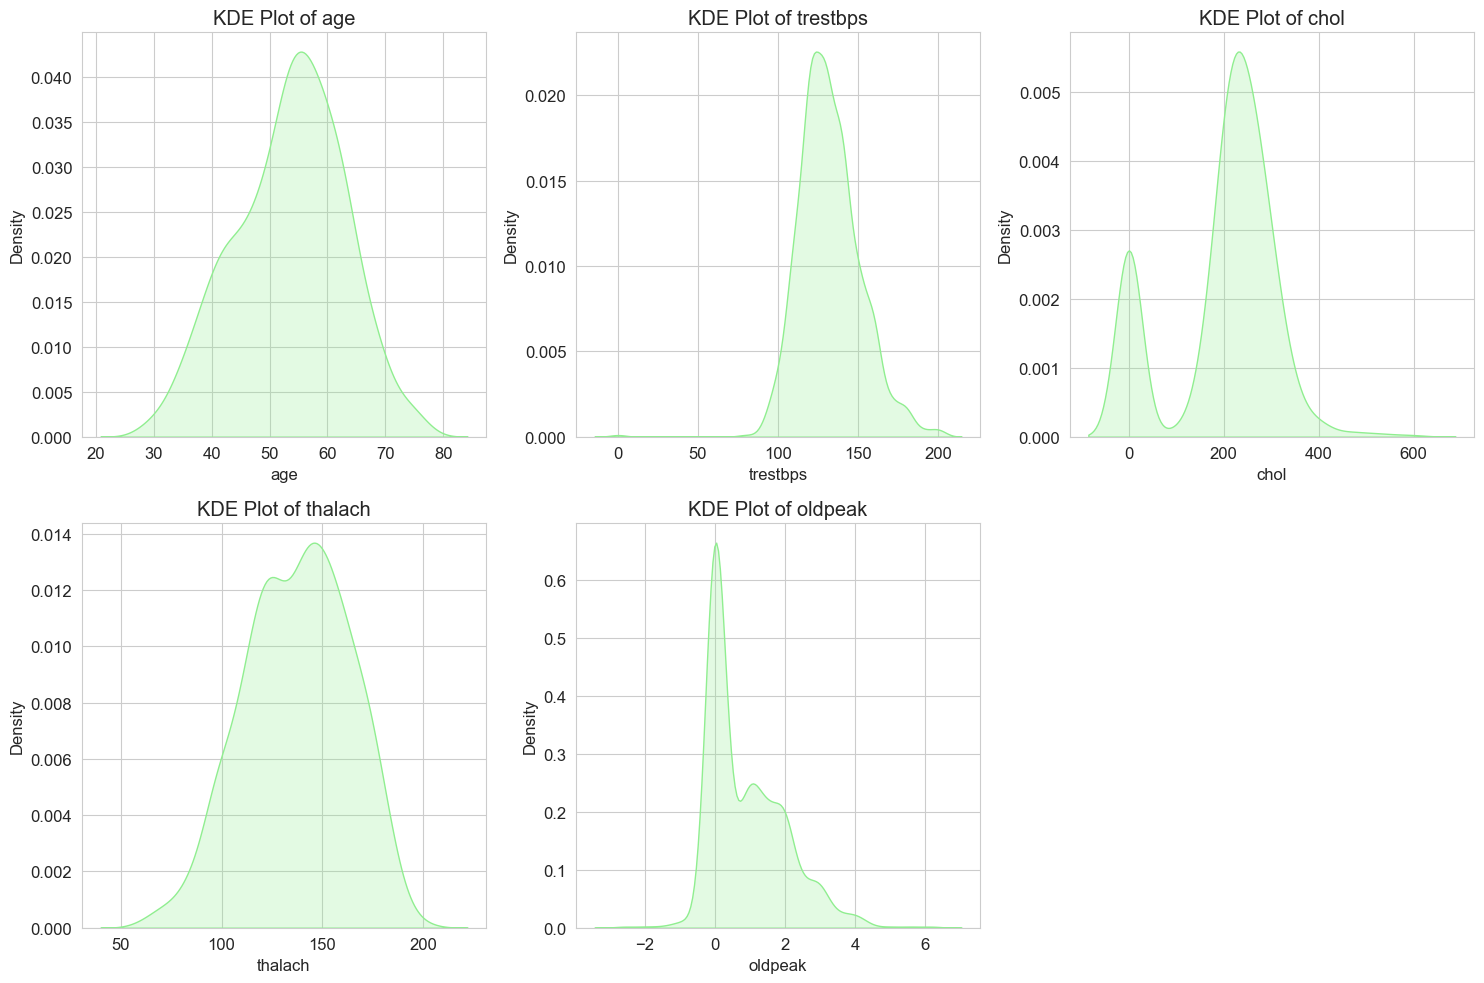

In [124]:
# Plotting KDE plots for continuous features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data[feature], fill=True, color='lightgreen')
    plt.title(f'KDE Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Notes on KDEs for Continuous Features
Checking KDEs for smoothness, bin bias, and less influence form outliers on plot

- Age: The age distribution has peaks around the early 50s and late 60s.

- Trestbps (Resting Blood Pressure): Similar to the simple histogram, most individuals have a resting blood pressure in the range of 120-140 mm Hg, with the distribution being somewhat right-skewed.

- Chol (Serum Cholestrol): Similar to the simple histogram, the majority of individuals have serum cholesterol levels in the range of 200-300 mg/dl. The distribution has a right-skewed tail.

- Thalach (Maximum Heart Rate Achieved): The heart rate distribution is slightly left-skewed, with a peak around the 160 bpm mark.

- Oldpeak (ST Depression Induced by Exercise Relative to Rest): Similar to the simple histogram, most values cluster around the lower range, indicating that many individuals have an oldpeak value of 0.

## Categorical Feature Distribution

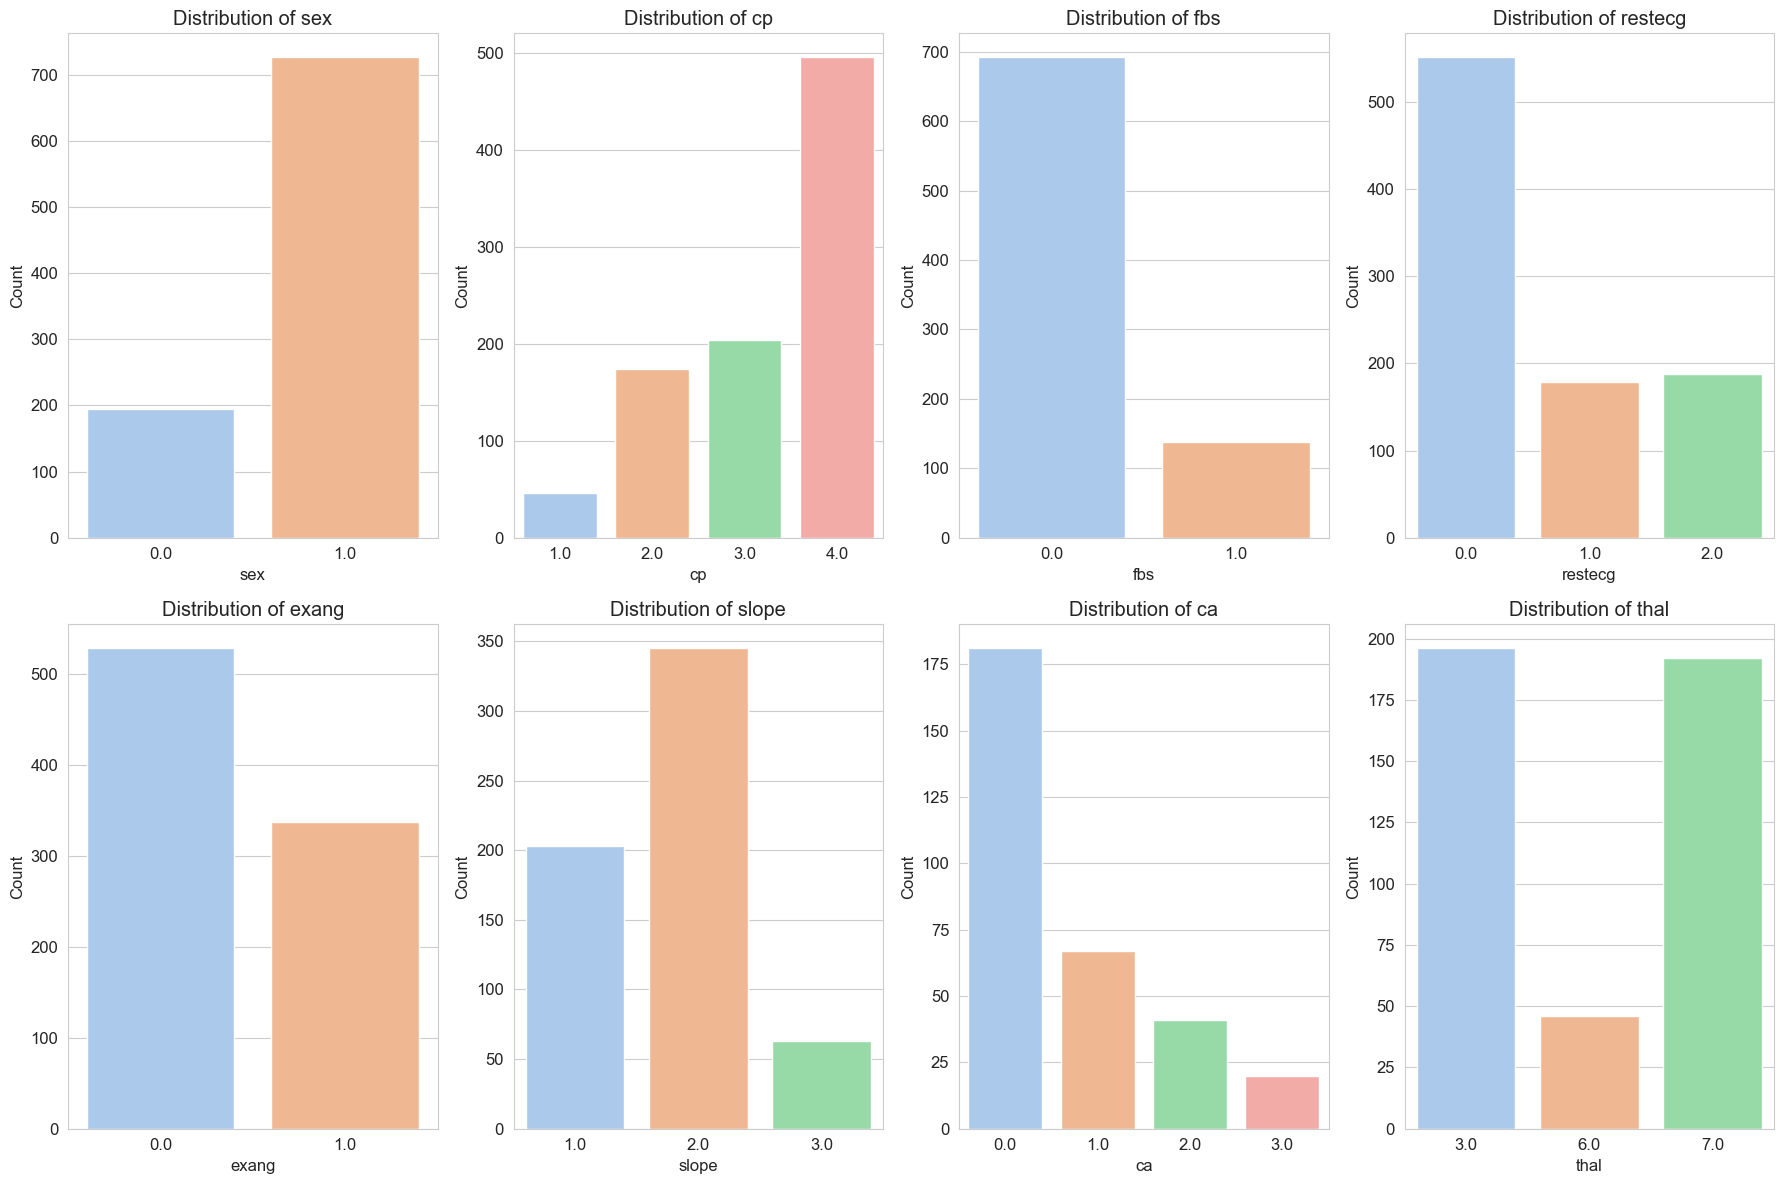

In [125]:
# Categorical features for visualization
sns.set_style("whitegrid")

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Plotting bar plots
plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, data=data, palette='pastel')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.rcParams.update({'font.size': 12})
    
plt.tight_layout()
plt.show()

### Notes on Categorical Features
- Sex: There are many more male individuals in the dataset than female.

- Cp (Chest Pain Type): The most common type of chest pain in the dataset is type 0, followed by type 2.

- Fbs (Fasting Blood Sugar): Most individuals have a fasting blood sugar less than 120 mg/dl.

- Restecg (Resting Electrocardiographic Results): The majority of individuals have a restecg value of 0 or 1.

- Exang (Exercise Induced Angina): Most individuals do not experience exercise-induced angina.

- Slope (Slope of the Peak Exercise ST Segment): Slope type 1 seems to be the most common, followed closely by type 2.

- Ca (Number of Major Vessels Colored by Flourosopy): Most individuals have 0 major vessels colored by flourosopy.

- Thal: The most common value appears to be 3, followed by 7.

### Population Demographics

In [126]:
#helper function for pie plots
def pie_chart_visualizations(data, features_for_charts, cmap=plt.cm.Blues(np.linspace(0.3, 1, 10))):
    # Set aesthetics
    sns.set_style("whitegrid")
    
    # Convert the cmap array into a callable colormap
    cmap = ListedColormap(cmap)
    
    # Separate grouped features (dictionaries) from standard features
    standard_features = [f for f in features_for_charts if not isinstance(f, dict)]
    grouped_features = [f for f in features_for_charts if isinstance(f, dict)]
    
    if len(standard_features) > 0:
        # Determine grid size for standard features
        n = len(standard_features)
        n_cols = 2
        n_rows = n // n_cols + (n % n_cols)

        # Plot standard features as subplots within a single figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7*n_rows))
        axes = axes.ravel() if n > 1 else [axes]

        for i, feature in enumerate(standard_features):
            vals = data[feature].value_counts()

            # If there are more than 6 unique values, group smaller frequencies into 'Other'
            if len(vals) > 6:
                other = vals.nsmallest(len(vals) - 6).sum()
                vals = vals.nlargest(6)
                vals['Other'] = other

            vals.plot(kind='pie', ax=axes[i], colormap=cmap, 
                      autopct=lambda p: f'{round(p*vals.sum()/100)} ({p:.1f}%)', 
                      textprops={'color': 'white', 'weight': 'bold', 'fontsize': 9, 
                                 'path_effects': [pe.withStroke(linewidth=3, foreground='black')]},
                      pctdistance=0.7)
            axes[i].set_title(f'Distribution of {feature}\nTotal Count: {vals.sum()}')
            axes[i].set_ylabel('')
            axes[i].legend(title=feature, loc="best")
    
        # If there are fewer plots than subplots, remove the extra axes
        for j in range(i+1, n_cols * n_rows):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    
    # Plot each grouped feature in a separate figure
    for feature_or_dict in grouped_features:
        feature = list(feature_or_dict.keys())[0]
        group_feature = feature_or_dict[feature]

        grouped = data.groupby([feature, group_feature]).size().unstack().fillna(0)
        
        fig, axes = plt.subplots(1, len(grouped.columns), figsize=(15, 7))
        axes = axes.ravel() if len(grouped.columns) > 1 else [axes]
            
        for i, col in enumerate(grouped.columns):
            vals = grouped[col]
            
            # If there are more than 6 unique values, group smaller frequencies into 'Other'
            if len(vals) > 6:
                other = vals.nsmallest(len(vals) - 6).sum()
                vals = vals.nlargest(6)
                vals['Other'] = other
                
            vals.plot(kind='pie', ax=axes[i], colormap=cmap, 
                      autopct=lambda p: f'{round(p*vals.sum()/100)} ({p:.1f}%)', 
                      textprops={'color': 'white', 'weight': 'bold', 'fontsize': 9, 
                                 'path_effects': [pe.withStroke(linewidth=3, foreground='black')]},
                      pctdistance=0.7)
            axes[i].set_title(f'{feature} by {group_feature} = {col}\nTotal Count: {vals.sum()}')
            axes[i].set_ylabel('')
            legend_title = f"{feature} ({group_feature} = {col})"
            axes[i].legend(title=legend_title, loc="best")
            
        plt.tight_layout()
        plt.show()

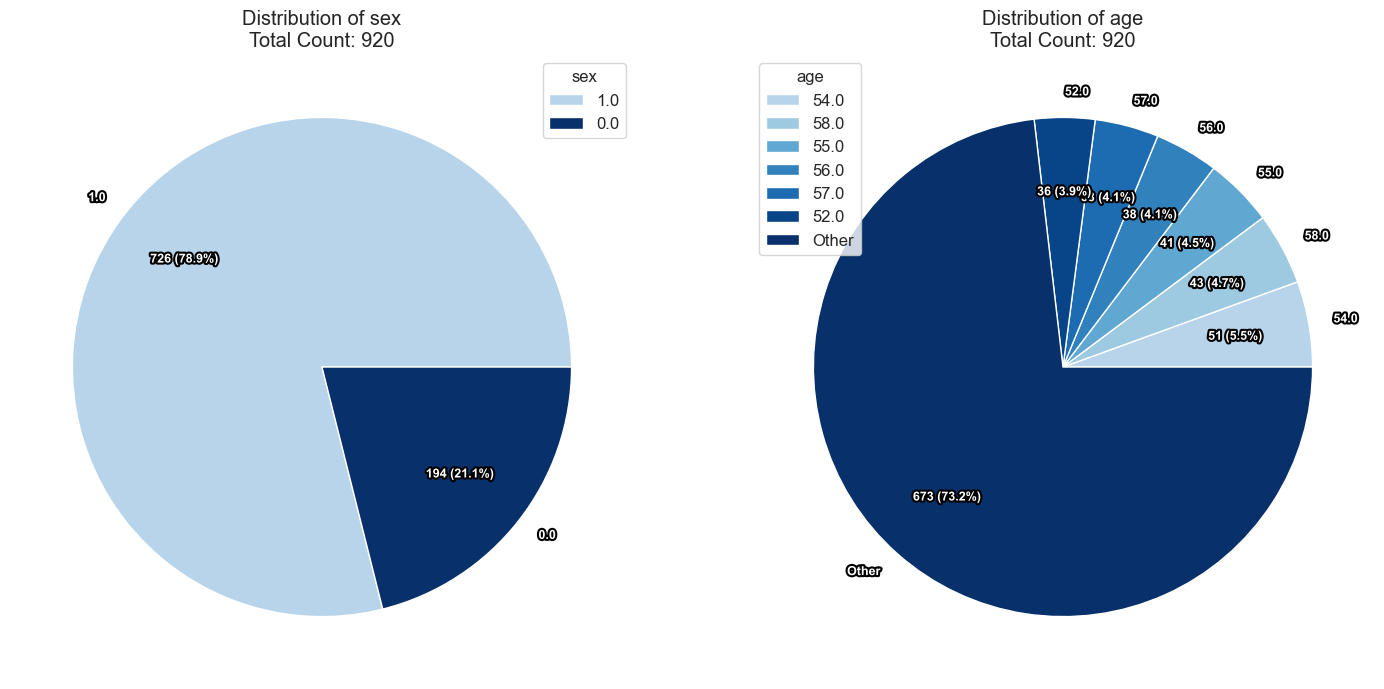

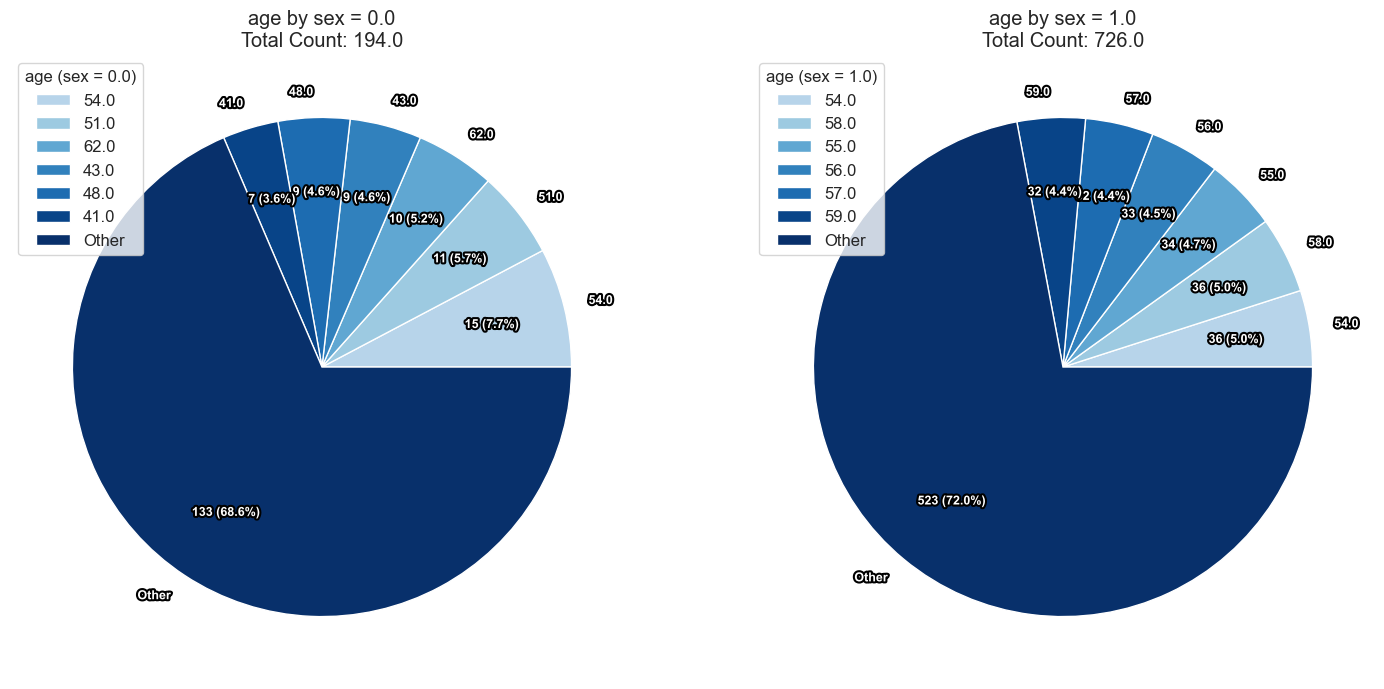

In [127]:
pie_chart_visualizations(data, ['sex', 'age', {'age':'sex'}])

### Notes on Population Demographics

We can see that sex is overwhelmingly male in this dataset (78.9%)

The greatest segments of the age distribution are found in the 50s age bracket

Women in the dataset present at seemingly distinct ages from the men, may be an issue of sample size.

# Dataset Health

## Missing Values

Recall from our look at categorical feature distributions that the following features had erroneous values that will need to be replaced with NaNs for handling during preprocessing.

- chol had significant 0 values for total cholesterol
- oldpeak had negative values
- trestbps had a single 0 value

In [128]:
#handling these erroneous values, filling with NaN
data.loc[data['chol'] == 0, 'chol'] = np.NaN
data.loc[data['oldpeak'] < 0, 'oldpeak'] = np.NaN
data.loc[data['trestbps'] == 0, 'trestbps'] = np.NaN

In [129]:
#Check for missing values
data.isna().sum()

age              0
sex              0
cp               0
trestbps        60
chol           202
fbs             90
restecg          2
thalach         55
exang           55
oldpeak         74
slope          309
ca             611
thal           486
institution      0
target           0
dtype: int64

Some of our features have significant numbers of NaN values

## Missing Values Distribution

In [130]:
def plot_nan_distributions(distributions, cmap=plt.cm.Blues(np.linspace(0.3, 1, 10))):
    num_distributions = len(distributions)
    num_cols = 3
    num_rows = int(np.ceil(num_distributions / num_cols))
    
    # Set up figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    # If there's only one row, axes will be a 1D array, so we reshape it to 2D
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, distribution in enumerate(distributions):
        ax = axes[idx // num_cols, idx % num_cols]
        column = distribution.index.name
        vals = distribution['count']
        
        #colormap switching to fix an odd visual artifact
        if 'NaN' in vals.index:
            nan_color = '#cd4f39'
            non_nan_color = cmap(0.7)
            custom_colors = [nan_color if idx == 'NaN' else non_nan_color for idx in vals.index]
            custom_cmap = ListedColormap(custom_colors)
        else:
            custom_cmap = cmap
        
        # Plot the NaN distribution
        vals.plot(kind='pie', ax=ax, colormap=custom_cmap, 
                  autopct=lambda p: f'{round(p*vals.sum()/100)} ({p:.1f}%)', 
                  textprops={'color': 'white', 'weight': 'bold', 'fontsize': 9, 
                             'path_effects': [pe.withStroke(linewidth=3, foreground='black')]},
                  pctdistance=0.7)
        
        ax.set_title(f'NaN Distribution of {column}\nTotal Count: {vals.sum()}')
        ax.set_ylabel('')
        ax.legend(title=column, loc="best")
    
    # Remove unused subplots
    for idx in range(num_distributions, num_rows * num_cols):
        fig.delaxes(axes.flatten()[idx])
    
    plt.tight_layout()
    plt.show()

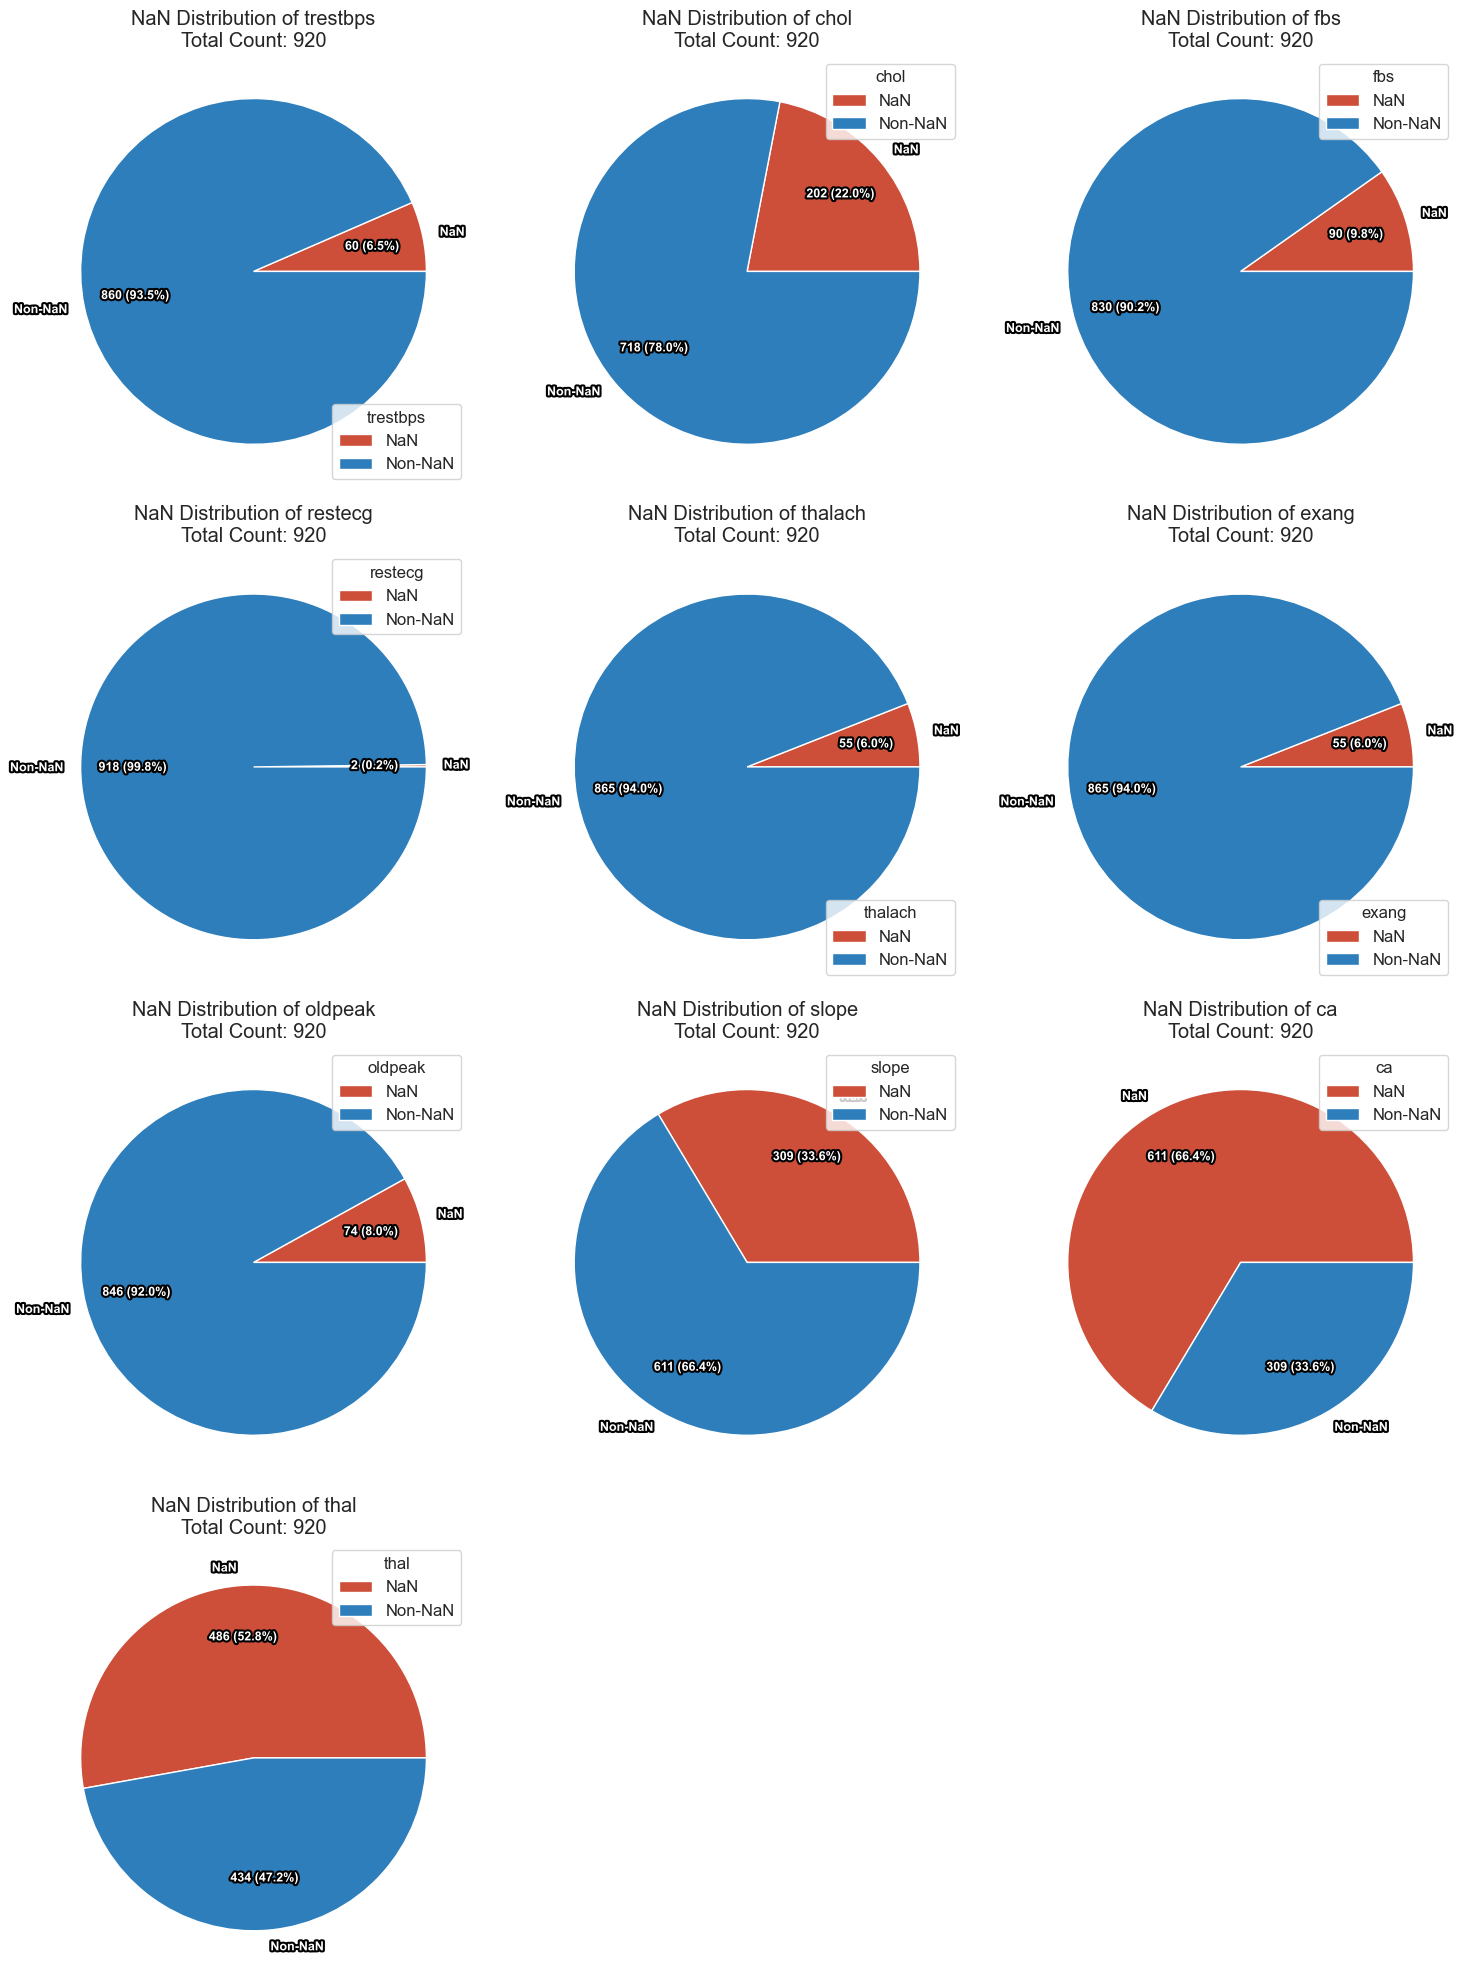

In [131]:
nan_distributions = []

nan_columns = data.isna().sum()[data.isna().sum() > 0].index

for column in nan_columns:
    nan_count = data[column].isna().sum()
    non_nan_count = len(data) - nan_count
    
    # Create a temporary DataFrame to represent the NaN distribution for the column
    temp_df = pd.DataFrame({
        column: ['NaN', 'Non-NaN'],
        'count': [nan_count, non_nan_count]
    }).set_index(column)
    
    nan_distributions.append(temp_df)

# Use plot_nan_distributions function to plot the NaN distributions
plot_nan_distributions(nan_distributions, plt.cm.Blues)

### Notes on NaN Distribution

chol, slope, ca, and thal have a large number of NaN values (22.0%, 33.6%, 66.4%, 52.8%); this will need to be taken into account during data preprocessing as simpleimputing will greatly alter the dataset.

In the preprocessing pipeline we should fill these NaNs with an out of range value such as -999 to indicate to the model that we have unusual values present other than the normal relationship. 

KNNClassification might be possible as an imputation step as well, but was dropped due to time limitations and unexpected technical dificulties.

## Columns with Large Standard Deviation

In [132]:
#Some features showed large deviations within the dataset
data.describe().T[['mean', 'std', 'min', 'max']].sort_values(by=['std'], ascending = False).iloc[:4, :]

,mean,std,min,max
chol,246.832869,58.527062,85.0,603.0
thalach,137.545665,25.926276,60.0,202.0
trestbps,132.286047,18.536175,80.0,200.0
age,53.510870,9.424685,28.0,77.0


These columns likely have outliers that could affect the quality of our training data.

Notably chol has a standard deviation greater than 100 and a max over 600 indicating the presence ov *very* high cholesterol in some of the patient data.

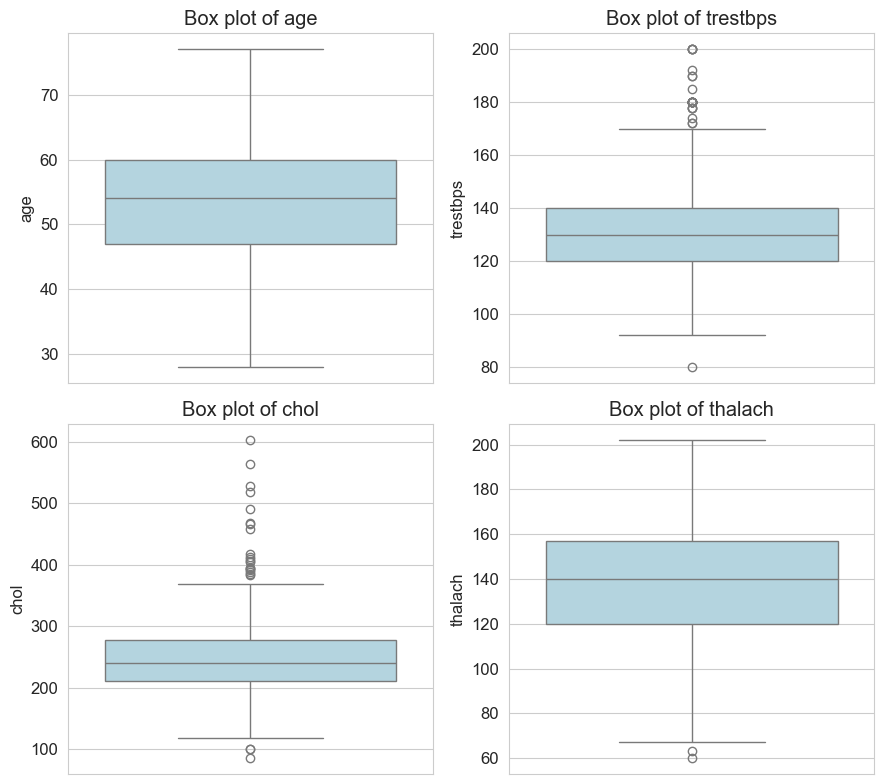

In [133]:
# Columns with a large standard deviation
std_dev_columns = ['age', 'trestbps', 'chol', 'thalach']

# Plotting box plots for columns with large standard deviation
plt.figure(figsize=(9, 8))
for i, column in enumerate(std_dev_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data[column], color='lightblue')
    plt.title(f'Box plot of {column}')

plt.tight_layout()
plt.show()

### Notes on columns with a large standard deviation
- Age: The distribution appears fairly symmetrical without any noticeable outliers.

- Trestbps (Resting Blood Pressure): The data has a few potential outliers on the higher end.

- Chol (Serum Cholestrol): The data shows potential outliers on both the lower and higher ends, with some fairly extreme upper values.

- Thalach (Maximum Heart Rate Achieved): The data is slightly left-skewed with some outliers on the lower end.

We will include scalers in our preprocessing pipeline to help with the skewness of our data.

In [134]:
#Lets identify the extreme outliers
columns_w_outliers = []
for column in data.columns:
    if data[column].dtype in ['int64', 'float64']:  # only consider numeric columns
        
        #Identify extreme outliers using quantiles
        Q1 = data[column].quantile(0.15)
        Q3 = data[column].quantile(0.85)
        IQR = Q3 - Q1
        outliers = data[(data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))]
        
        if not outliers.empty:
            print("\nOutlier values for {} : \n{}".format(column, outliers[column].values))
            columns_w_outliers.append({column : (outliers[column].values, outliers[column].index.tolist())})

print("\nColumns with outliers:", [list(d.keys())[0] for d in columns_w_outliers])


Outlier values for chol : 
[564. 468. 466. 529. 603. 518. 491. 458.]

Outlier values for oldpeak : 
[6.2 5.6]

Columns with outliers: ['chol', 'oldpeak']


How do these upper cholesterol values impact heart disease...

In [135]:
filtered_data = data.loc[data['chol'] >= data['chol'].quantile(0.85), ['chol', 'target']]

grouped = filtered_data.groupby('target')['chol'].agg(['count', 'min', 'max', 'mean'])

print(grouped)

        count    min    max        mean
target                                 
0          51  298.0  564.0  337.921569
1          33  298.0  603.0  362.151515
2          12  305.0  409.0  331.750000
3          13  298.0  369.0  322.076923
4           3  304.0  407.0  343.000000


In [136]:
filtered_data = data.loc[data['chol'] >= data['chol'].quantile(0.95), ['chol', 'target']]

grouped = filtered_data.groupby('target')['chol'].agg(['count', 'min', 'max', 'mean'])

print(grouped)

        count    min    max        mean
target                                 
0          15  342.0  564.0  397.466667
1          15  341.0  603.0  416.933333
2           3  341.0  409.0  378.000000
3           2  353.0  369.0  361.000000
4           1  407.0  407.0  407.000000


The high values counter-intuitively do not necessarily indicate heart disease, it may be useful to remove the extreme outliers in chol from the dataset.

Looking at varying quantiles, we may want to filter from a greater percentile than the 85th.

We will remove below the 95th percentile in our data preprocessing pipeline.

How do these upper oldpeak (ST depression induced by exercise) values impact heart disease...

In [137]:
filtered_data = data.loc[data['oldpeak'] >= data['oldpeak'].quantile(0.85), ['oldpeak', 'target']]

grouped = filtered_data.groupby('target')['oldpeak'].agg(['count', 'min', 'max', 'mean'])

print(grouped)

        count  min  max      mean
target                           
0          23  2.0  4.2  2.360870
1          58  2.0  5.0  2.413793
2          39  2.0  4.0  2.574359
3          38  2.0  6.2  2.821053
4          18  2.0  4.4  3.022222


These outliers seem to be associated with heart disease, the outliers may be useful to keep in the feature. 

### Feature Correlation with Target


Columns with outliers: ['chol', 'oldpeak']


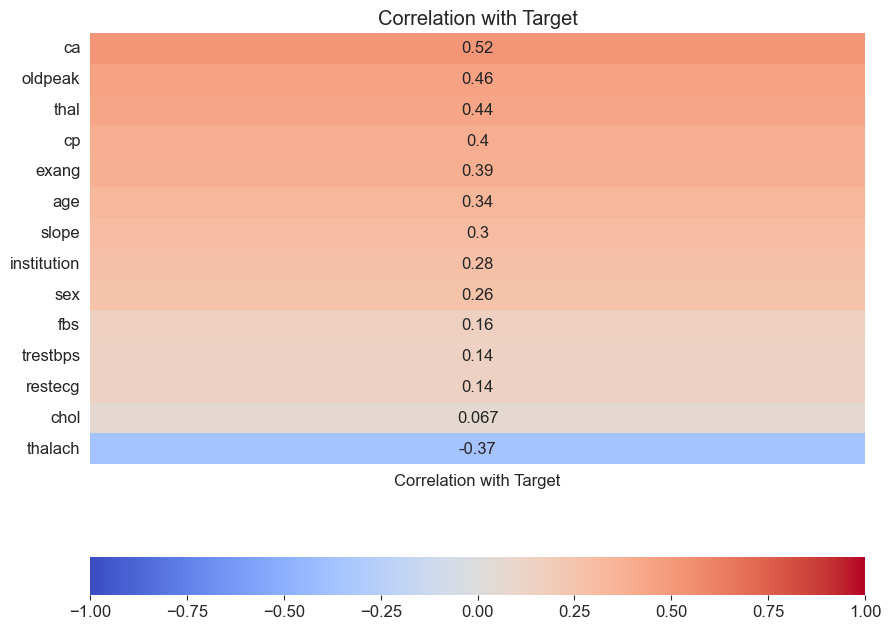

In [138]:
#keep our extreme outlier columns in mind here...
print("\nColumns with outliers:", [list(d.keys())[0] for d in columns_w_outliers])

#calculate per feature correlation with target feature
correlations_with_target = data.drop("target", axis=1).apply(lambda x: x.corr(data.target))

# Convert the series to a dataframe for visualization
correlations_with_target = correlations_with_target.to_frame(name='Correlation with Target')

plt.figure(figsize=(10, 8))
sns.heatmap(correlations_with_target.sort_values(by='Correlation with Target', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={'orientation': 'horizontal'})
plt.title('Correlation with Target')
plt.show()

Let's look at this again with the extreme cholesterol outliers removed, it's a bit counter-intuitive to see extremely high total cholesterol values not correlated with heart disease...

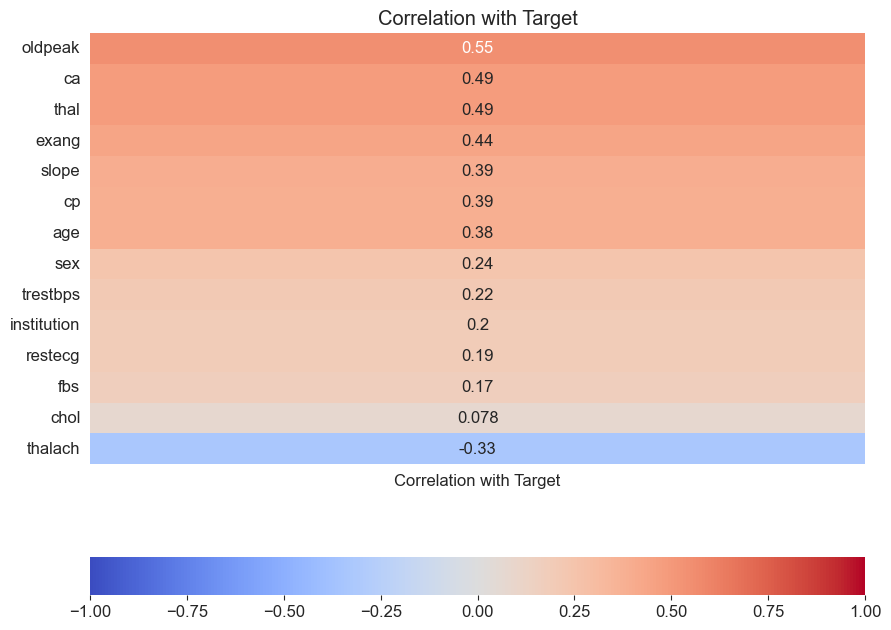

In [139]:
#calculate per feature correlation with target feature, this time ignoring the upper end of cholesterol range
#   by filtering to values below the 85th percentile
correlations_with_target = data[data['chol'] <= data['chol'].quantile(0.95)].drop("target", axis=1).apply(lambda x: x.corr(data[data['chol'] <= data['chol'].quantile(0.85)].target))

# Convert the series to a dataframe for visualization
correlations_with_target = correlations_with_target.to_frame(name='Correlation with Target')

plt.figure(figsize=(10, 8))
sns.heatmap(correlations_with_target.sort_values(by='Correlation with Target', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={'orientation': 'horizontal'})
plt.title('Correlation with Target')
plt.show()

In [140]:
data['chol'].quantile(0.95)

340.15

Removing extreme outliers (> ~340 mg/dl), improves overall correlation.

It is likely useful to remove these rows as they represent patients with counter-intuitive health outcomes that will likely negatively affect our model quality.

We will incorporate this into the Data Processing Pipeline.

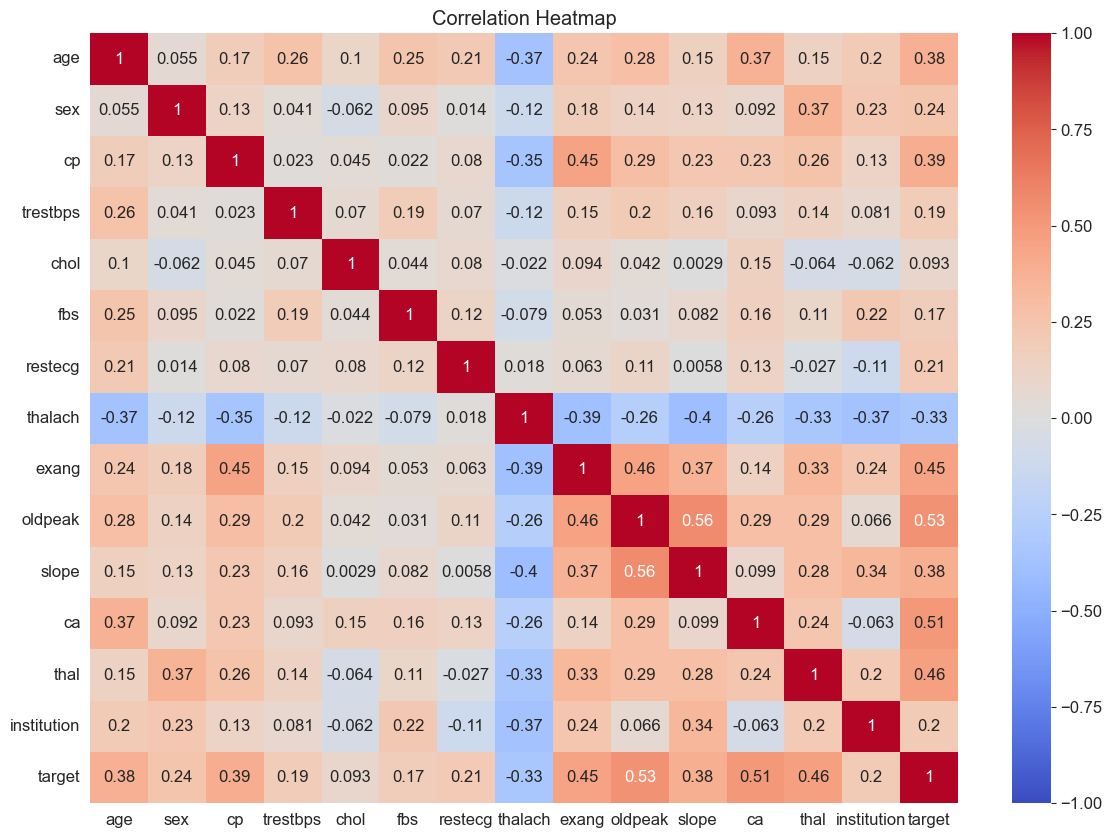

In [141]:
#let's look at the correlation heatmap

#filtering data to remove these extreme chol values
correlation_matrix = data[data['chol'] <= data['chol'].quantile(0.95)].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

oldpeak and slope may indicate strong correlation, but we know that slope is a characteristic of what is measured by oldpeak so this is likely fine for our categorical data

# Data Processing Pipeline
- Using what we've gathered from exploration above, we will implement an efficient pipeline to prepare our data for training and comparing some classifiers to predict our target heart disease feature

In [142]:
def get_transformed_columns(preprocessor, original_data):
    transformed_names = []
    input_features = original_data.columns.tolist()
    
    all_transformed_columns = []
    
    # Extract columns from each transformer
    for _, _, columns in preprocessor.transformers_:
        if callable(columns):
            selected_cols = list(columns(original_data))
        else:
            selected_cols = columns
        all_transformed_columns.extend(selected_cols)

    # Determine columns that are passed through
    passthrough_columns = [col for col in input_features if col not in all_transformed_columns]
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == "drop" or transformer == "drop":
            continue

        if isinstance(transformer, Pipeline):
            transformer = transformer[-1]  # Get the last step in the pipeline

        # If the transformer has a get_feature_names_out method (like OneHotEncoder)
        if hasattr(transformer, 'get_feature_names_out'):
            if callable(columns):
                columns = list(columns(original_data))
            names = list(transformer.get_feature_names_out(input_features=columns))
            transformed_names.extend(names)
        else:
            transformed_names.extend(columns)

    # Add passthrough columns
    transformed_names.extend(passthrough_columns)
    
    return transformed_names

In [143]:
#helper function to programatically classify our features for the preprocessing pipeline
def classify_features(df):
    numerical_features = []
    binary_categorical_features = []
    multi_categorical_features = []
    
    for column in df.columns:
        # Exclude target column if it exists
        if column == "target":
            continue
        
        # Numerical features
        if df[column].dtype in ['int64', 'float64'] and len(df[column].unique()) > 10:
            numerical_features.append(column)
            
        # Binary categorical features
        elif len(df[column].unique()) == 2:
            binary_categorical_features.append(column)
            
        # Multi-categorical features
        else:
            multi_categorical_features.append(column)
    
    return numerical_features, binary_categorical_features, multi_categorical_features

In [144]:
def preprocessing_pipeline(
    dataframe,
    target='target',
    X=None,
    y=None,
    scale=True,
    encode=True,
    split=True,
    debug=False
):
    if split:
        target_feature = [target]
    else:
        target_feature = []
    
    # Remove rows associated with the extreme outliers in 'chol'
    dataframe = dataframe[dataframe['chol'] <= dataframe['chol'].quantile(0.95)]
    
    # Handle erroneous values
    dataframe.loc[dataframe['chol'] == 0, 'chol'] = np.NaN
    dataframe.loc[dataframe['oldpeak'] < 0, 'oldpeak'] = np.NaN
    dataframe.loc[dataframe['trestbps'] == 0, 'trestbps'] = np.NaN
    
    #shuffle using pandas sample
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    
    feature_types = ['numerical_features', 'binary_categorical_features', 'multi_categorical_features']
    
    numerical_features, binary_categorical_features, multi_categorical_features = classify_features(dataframe)
    dataframe[binary_categorical_features] = dataframe[binary_categorical_features].astype("category")
    dataframe[multi_categorical_features] = dataframe[multi_categorical_features].astype("category")
    
    if debug:
        for feature_type, features in zip(feature_types, [numerical_features, binary_categorical_features, multi_categorical_features]):
            print("{} are : {}".format(feature_type, features))
            
    # Identify features with more than 20% missing values
    high_nan_features = [col for col in dataframe.columns if ((dataframe[col].isna().sum() / len(dataframe[col])) >= 0.2)]
    
    if debug:
        print("high_nan_features : {}".format(high_nan_features))
    
    # Define pipelines for each group of features
    if scale:
        high_nan_pipeline = make_pipeline(
            SimpleImputer(strategy='constant', fill_value=-999),
            RobustScaler()
        )

        numeric_pipeline = make_pipeline(
            SimpleImputer(strategy='median'),
            StandardScaler()
        )
        
        binary_cat_pipeline = make_pipeline(
            SimpleImputer(strategy='most_frequent')
        )
        
    elif scale == False:
        high_nan_pipeline = make_pipeline(
            SimpleImputer(strategy='constant', fill_value= -999)
        )

        numeric_pipeline = make_pipeline(
            SimpleImputer(strategy='median')
        )

        binary_cat_pipeline = make_pipeline(
            SimpleImputer(strategy='most_frequent')
        )
    
    if encode:
        multi_cat_pipeline = make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown='ignore')
        )
        
    else:
        multi_cat_pipeline = make_pipeline(
            SimpleImputer(strategy='most_frequent')
        )

    # nan_processing
    nan_preprocessor = ColumnTransformer(
        transformers=[
            ('pass', 'passthrough', dataframe.columns.difference(high_nan_features + target_feature)),
            ('high_nan', high_nan_pipeline, high_nan_features)
            
        ],
        remainder='passthrough'  # Any other columns not specified will be passed through without changes
    )
    
    # Bundle preprocessing for all features
    preprocessor = ColumnTransformer(
        transformers=[
            ('pass', 'passthrough', dataframe.columns.difference(numerical_features + binary_categorical_features + multi_categorical_features + target_feature)),
            ('numeric', numeric_pipeline, numerical_features),
            ('binary_cat', binary_cat_pipeline, binary_categorical_features),
            ('multi_cat', multi_cat_pipeline, multi_categorical_features)
        ],
        remainder='passthrough'  # Any other columns not specified will be passed through without changes
    )
    
    if debug:
        for name, pipe_line in zip(['high_NaN', 'numeric', 'bin_cat', 'multi_cat'], [high_nan_pipeline, numeric_pipeline, binary_cat_pipeline, multi_cat_pipeline]):
            print("{} : \n{}".format(name, pipe_line))
        
    if split:
        #define our X and y if not present
        if (X is not None) and (y is not None):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        else:
            X, y = dataframe[dataframe.columns.difference([target])], dataframe[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        if len(high_nan_features) > 0:
            #nan_preprocessing the data
            X_train_nan_preprocessed = nan_preprocessor.fit_transform(X_train)
            X_train_nan_preprocessed = pd.DataFrame(X_train_nan_preprocessed, columns=get_transformed_columns(nan_preprocessor, X_train))

            X_test_nan_preprocessed = nan_preprocessor.transform(X_test)
            X_test_nan_preprocessed = pd.DataFrame(X_test_nan_preprocessed, columns=get_transformed_columns(nan_preprocessor, X_train))

            #Preprocessing the data
            X_train_preprocessed = preprocessor.fit_transform(X_train_nan_preprocessed)
            X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=get_transformed_columns(preprocessor, X_train_nan_preprocessed))

            X_test_preprocessed = preprocessor.transform(X_test_nan_preprocessed)
            X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=get_transformed_columns(preprocessor, X_train_nan_preprocessed))
        
        else:
            X_train_preprocessed = preprocessor.fit_transform(X_train)
            X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=get_transformed_columns(preprocessor, X_train))

            X_test_preprocessed = preprocessor.transform(X_test)
            X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=get_transformed_columns(preprocessor, X_train))
        
        return X_train_preprocessed, X_test_preprocessed, y_train, y_test
    
    else:
        if len(high_nan_features) > 0:
            nan_processed_data = nan_preprocessor.fit_transform(dataframe)
            nan_processed_data = pd.DataFrame(nan_processed_data, columns=get_transformed_columns(nan_preprocessor, dataframe))

            processed_data = preprocessor.fit_transform(nan_processed_data)
            processed_data = pd.DataFrame(processed_data, columns=get_transformed_columns(preprocessor, nan_processed_data))
        else:
            processed_data = preprocessor.fit_transform(dataframe)
            processed_data = pd.DataFrame(processed_data, columns=get_transformed_columns(preprocessor, dataframe))
        
        return processed_data[dataframe.columns]

## Feature Engineering

- Some approaches to engineering additional features to hopefully improve model performance

In [145]:
#first a simple means of evaluating our engineered features with a RandomForest
def evaluate_feature_importances(data):
    # Drop target column and one-hot encode the dataframe
    X = data.drop('target', axis=1)
    X = pd.get_dummies(X)
    y = data['target']
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)

    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature rankings
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

In [146]:
data = preprocessing_pipeline(pull_grouped_hd_data(default_print=False), encode=False, split=False, scale=False)
data

cleveland written to C:\data\processed.cleveland.data
cleveland written to C:\data\processed.cleveland.data
hungary written to C:\data\processed.hungarian.data
switzerland written to C:\data\processed.switzerland.data
veterans_affairs written to C:\data\processed.va.data


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,institution,target
0,54.0,1.0,4.0,130.0,-999.0,0.0,1.0,140.0,0.0,0.5,-999.0,-999.0,-999.0,3.0,3.0
1,55.0,0.0,4.0,180.0,327.0,0.0,1.0,117.0,1.0,3.4,2.0,0.0,3.0,0.0,2.0
2,59.0,1.0,4.0,135.0,234.0,0.0,0.0,161.0,0.0,0.5,2.0,0.0,7.0,0.0,0.0
3,55.0,1.0,3.0,120.0,-999.0,0.0,1.0,125.0,1.0,2.5,2.0,-999.0,7.0,3.0,1.0
4,58.0,1.0,2.0,120.0,284.0,0.0,2.0,160.0,0.0,1.8,2.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,51.0,1.0,4.0,130.0,-999.0,0.0,0.0,170.0,0.0,0.5,1.0,-999.0,-999.0,2.0,2.0
841,62.0,1.0,4.0,152.0,153.0,0.0,1.0,97.0,1.0,1.6,1.0,-999.0,7.0,3.0,2.0
842,40.0,1.0,2.0,130.0,275.0,0.0,0.0,150.0,0.0,0.0,-999.0,-999.0,-999.0,1.0,0.0
843,56.0,1.0,4.0,128.0,223.0,0.0,1.0,119.0,1.0,2.0,3.0,-999.0,-999.0,3.0,2.0


In [147]:
#run once to see base importances
evaluate_feature_importances(data)

Feature ranking:
1. feature age (0.128346)
2. feature thalach (0.120952)
3. feature chol (0.120016)
4. feature trestbps (0.102674)
5. feature oldpeak (0.102243)
6. feature cp (0.090105)
7. feature institution (0.067423)
8. feature slope (0.051671)
9. feature thal (0.050107)
10. feature exang (0.042533)
11. feature ca (0.041554)
12. feature restecg (0.038292)
13. feature fbs (0.023735)
14. feature sex (0.020348)


Importances seem relatively low overall with our top 5 most important base features being:

- age
- thalach (max heart rate)
- chol
- oldpeak (exercise induced ST depression)
- trestbps (rest blood pressure)

### Binning

- Binning features may provide us with a more informative relationship between features and heart disease as the continuous format may be too restrictive on the current dataset size

In [148]:
#age_bin
#Setting some age brackets for our binned_age feature
age_bins = [0, 18, 25, 40, 55, 65, 75, data['age'].max()+1]
age_labels = ['0-18', '18-25', '25-40', '40-55', '55-65', '65-75', '75+']
#create age_bin
data['age_bin'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

#trestbps_bin
# using CDC catagories for Systolic Blood Pressure
# https://www.cdc.gov/bloodpressure/facts.htm
bps_bins = [0, 120, 129, 139, data['trestbps'].max()+1]
bps_labels = ['Normal', 'Elevated', 'Hypertension_I', 'Hypertension_II']
data['trestbps_bin'] = pd.cut(data['trestbps'], bins=bps_bins, labels=bps_labels, right=False)

#chol_bin
# Using total cholesterol categories from medlineplus.gov
#https://medlineplus.gov/lab-tests/cholesterol-levels/#:~:text=What%20do%20the%20results%20mean?
chol_bins = [-999, 0, 200, 239, data['chol'].max()+1]
chol_labels = ['Filled_NaN', 'Desirable', 'Borderline', 'High']
data['chol_bin'] = pd.cut(data['chol'], bins=chol_bins, labels=chol_labels, right=False)

### Binned Feature Distributions

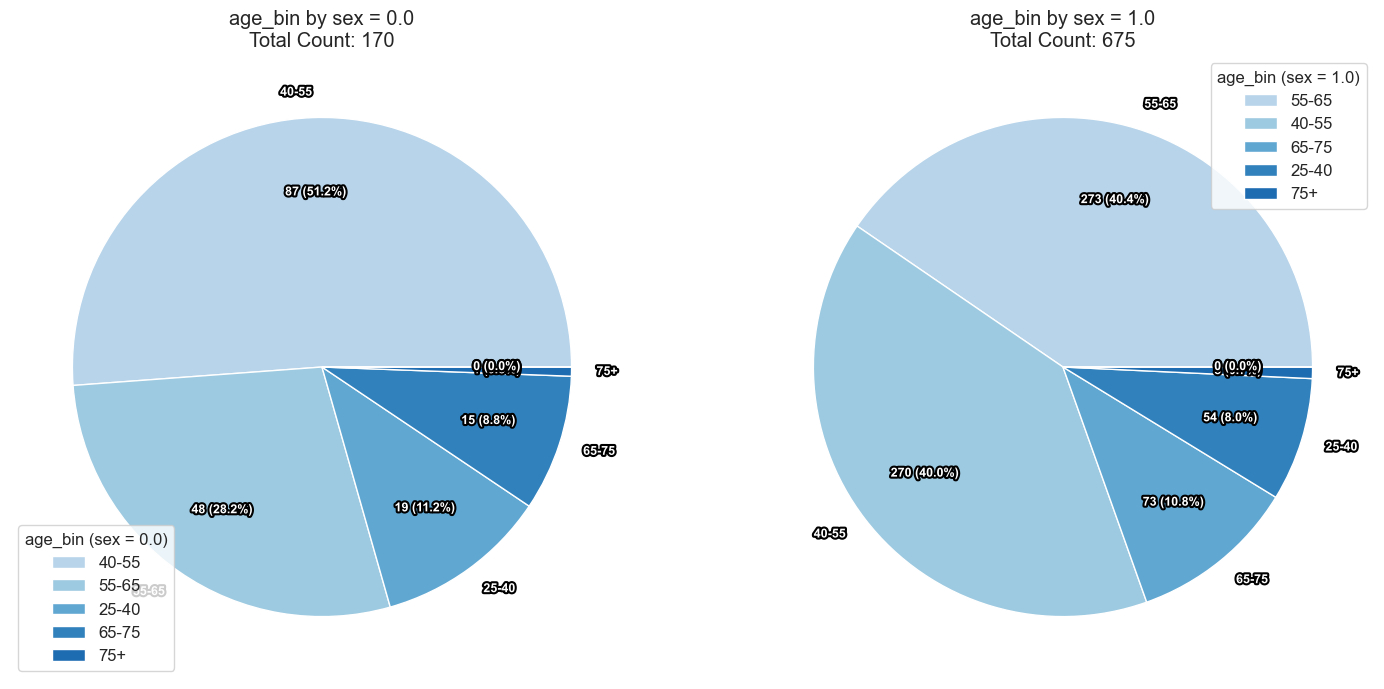

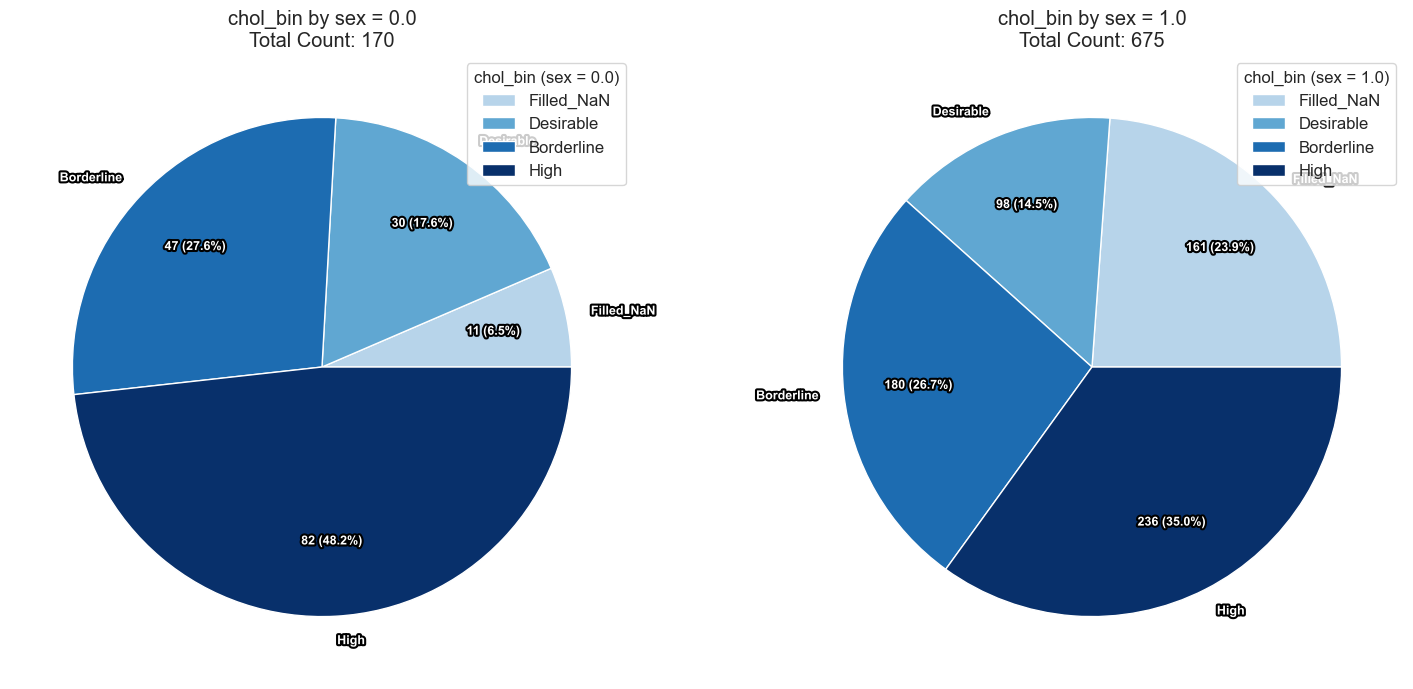

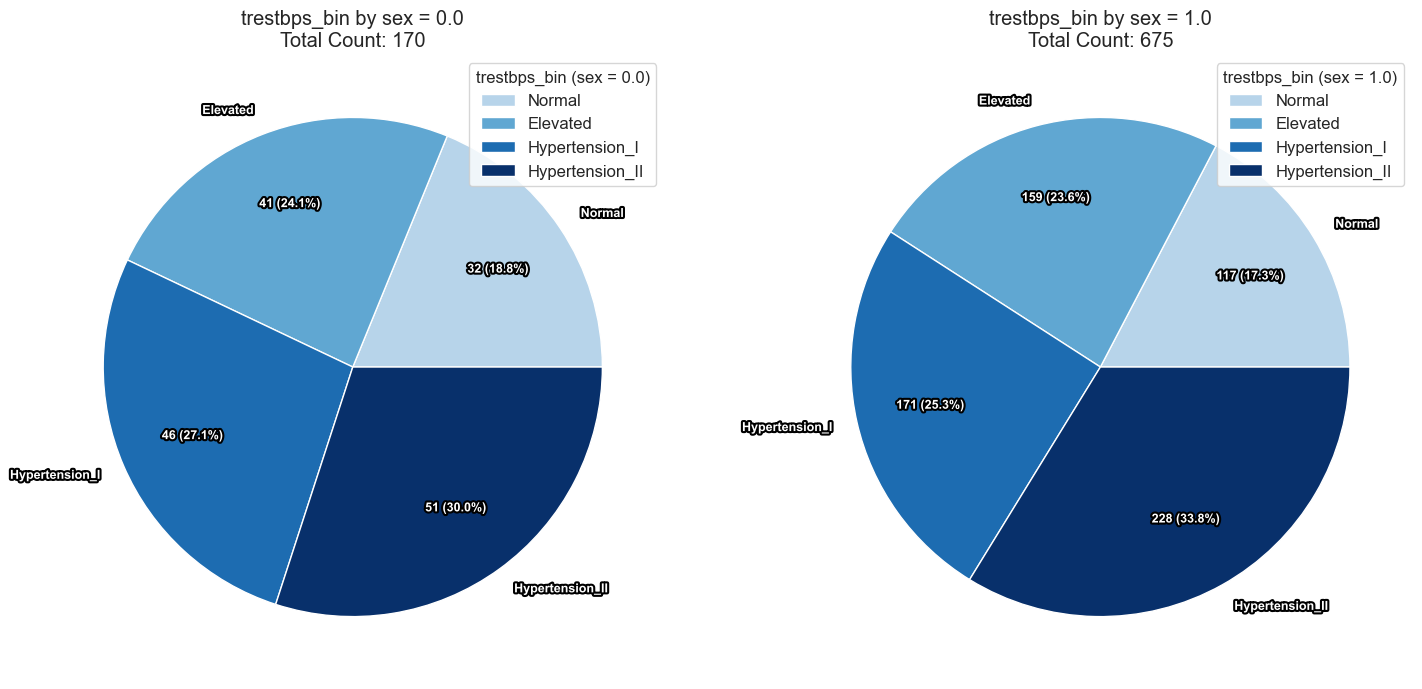

In [149]:
pie_chart_visualizations(data, [{'age_bin': 'sex'}, {'chol_bin':'sex'}, {'trestbps_bin': 'sex'}])

In [150]:
#run once to see binned feature importances
evaluate_feature_importances(data)

Feature ranking:
1. feature thalach (0.109036)
2. feature age (0.103623)
3. feature oldpeak (0.091411)
4. feature chol (0.087303)
5. feature cp (0.079562)
6. feature trestbps (0.077577)
7. feature institution (0.058639)
8. feature slope (0.047540)
9. feature thal (0.045547)
10. feature exang (0.041009)
11. feature ca (0.039470)
12. feature restecg (0.033500)
13. feature fbs (0.018423)
14. feature sex (0.018290)
15. feature chol_bin_Filled_NaN (0.017534)
16. feature age_bin_55-65 (0.017316)
17. feature chol_bin_Borderline (0.015763)
18. feature trestbps_bin_Elevated (0.013451)
19. feature trestbps_bin_Hypertension_I (0.013155)
20. feature age_bin_40-55 (0.012972)
21. feature trestbps_bin_Normal (0.012654)
22. feature trestbps_bin_Hypertension_II (0.012409)
23. feature chol_bin_High (0.011652)
24. feature age_bin_65-75 (0.009212)
25. feature chol_bin_Desirable (0.009030)
26. feature age_bin_25-40 (0.002325)
27. feature age_bin_75+ (0.001596)
28. feature age_bin_18-25 (0.000000)
29. featu

only minor feature importances from our bins, but we'll move ahead with these features

chol_bin_Filled_NaN seems the most important engineered feature 

### Interacting Features/Combinant Features

emphasizing the expected interactions of features through multiplying two or more features may produce useful relationships

Eg.
- age_sex demographic interaction

- cp_exang chest_pain and exercise_angina interaction

- thalach_exang maximum heart rate and exercise_angina interaction

In [151]:
data['age_sex'] = data['age'] * data['sex']
data['age_chol'] = data['age'] * data['chol']
data['sex_chol'] = data['sex'] * data['chol']

data['age_institution'] = data['age'] * data['institution']
data['chol_institution'] = data['chol'] * data['institution']


data['oldpeak_slope'] = data['oldpeak'] * data['slope']

data['cp_exang'] = data['cp'] * data['exang']
data['thalach_exang'] = data['thalach'] * data['exang']

data['thalach_restecg'] = data['thalach'] * data['restecg']

In [152]:
#some complex thalach binning based on feature interaction 
# using cleveland clinic/AHA's target and avg max heart rate bins
# https://health.clevelandclinic.org/exercise-heart-rate-zones-explained/#:~:text=How%20do%20I%20find%20my%20target%20heart%20rate?

#define some helper functions

#find max target heart rate based on age
def get_max_target_rates(age):
    """Returns the max and target heart rate based on age."""
    #check if in age range in clinic chart
    if 20 <= age < 30:
        # (max_rate, (min_target_rate, max_target_rate))
        return 200, (100, 170)  
    elif 30 <= age < 35:
        return 190, (95, 162)
    elif 35 <= age < 40:
        return 185, (93, 157)
    elif 40 <= age < 45:
        return 180, (90, 153)
    elif 45 <= age < 50:
        return 175, (88, 149)
    elif 50 <= age < 55:
        return 170, (85, 145)
    elif 55 <= age < 60:
        return 165, (83, 140)
    elif 60 <= age < 65:
        return 160, (80, 136)
    elif 65 <= age < 70:
        return 155, (78, 132)
    else:
        return 150, (75, 128)

#determine if thalach in target heart rate zone
def in_target_heart_rate(row):
    """Determines if the heart rate is within the target range."""
    age = row['age']
    thalach = row['thalach']
    _, target_range = get_max_target_rates(age)
    
    return int(target_range[0] <= thalach <= target_range[1])

#determine if thalach exceeds the age-based average max heart rate
def exceeds_avg_max_heart_rate(row):
    """Determines if the heart rate exceeds the average max heart rate."""
    age = row['age']
    thalach = row['thalach']
    max_rate, _ = get_max_target_rates(age)
    
    return int(thalach > max_rate)

#apply to our data to make our new features based on age-thalach interaction/binning
data['in_target_heart_rate'] = data.apply(in_target_heart_rate, axis=1)
data['exceeds_avg_max_heart_rate'] = data.apply(exceeds_avg_max_heart_rate, axis=1)

In [153]:
#run once to see new feature importances
evaluate_feature_importances(data)

Feature ranking:
1. feature age_chol (0.076588)
2. feature thalach (0.061471)
3. feature age_institution (0.060637)
4. feature cp (0.058987)
5. feature age_sex (0.058296)
6. feature oldpeak_slope (0.053021)
7. feature oldpeak (0.050764)
8. feature age (0.050208)
9. feature trestbps (0.048423)
10. feature chol (0.045655)
11. feature sex_chol (0.042413)
12. feature thalach_exang (0.037488)
13. feature chol_institution (0.036675)
14. feature cp_exang (0.033358)
15. feature thalach_restecg (0.032996)
16. feature thal (0.029195)
17. feature slope (0.027570)
18. feature ca (0.025911)
19. feature institution (0.024939)
20. feature exang (0.015653)
21. feature restecg (0.014631)
22. feature fbs (0.012069)
23. feature trestbps_bin_Normal (0.009914)
24. feature in_target_heart_rate (0.009639)
25. feature trestbps_bin_Hypertension_I (0.009319)
26. feature trestbps_bin_Hypertension_II (0.008843)
27. feature age_bin_55-65 (0.008745)
28. feature trestbps_bin_Elevated (0.008677)
29. feature chol_bin_

Notably our age_institution, age_chol, age_sex, oldpeak_slope feature has high importance and sex_chol, chol_institution, thalach_exang, cp_exang, thalach_restecg has moderate importance

We will move ahead with our new features.

#### Note:

Domain level knowledge from a medical scientist may be useful for further feature engineering, but is well beyond the scope of this project.

# Feature Engineering Pipeline

In [154]:
def bin_column(data, column_name, bins, labels, new_column_name=None):
    """Generic binning function"""
    if not new_column_name:
        new_column_name = f"{column_name}_bin"
    data[new_column_name] = pd.cut(data[column_name], bins=bins, labels=labels, right=False)
    return data


def feature_engineering_pipeline(data=None, ignore=False):
    if data is None:
        data = data=preprocessing_pipeline(pull_grouped_hd_data(default_print=False), encode=False, split=False, scale=False)
    # Binning age
    age_bins = [0, 18, 25, 40, 55, 65, 75, data['age'].max() + 1]
    age_labels = ['0-18', '18-25', '25-40', '40-55', '55-65', '65-75', '75+']
    data = bin_column(data, 'age', age_bins, age_labels)

    # Binning trestbps
    bps_bins = [0, 120, 129, 139, data['trestbps'].max() + 1]
    bps_labels = ['Normal', 'Elevated', 'Hypertension_I', 'Hypertension_II']
    data = bin_column(data, 'trestbps', bps_bins, bps_labels)

    # Binning chol
    chol_bins = [-999, 0, 200, 239, data['chol'].max() + 1]
    chol_labels = ['Filled_NaN', 'Desirable', 'Borderline', 'High']
    data = bin_column(data, 'chol', chol_bins, chol_labels)

    # Basic Interaction features
    interactions = [
        ('age', 'sex'),
        ('age', 'chol'),
        ('sex', 'chol'),
        ('age', 'institution'),
        ('chol', 'institution'),
        ('oldpeak', 'slope'),
        ('cp', 'exang'),
        ('thalach', 'exang'),
        ('thalach', 'restecg')
    ]
    for col1, col2 in interactions:
        data[f"{col1}_{col2}"] = data[col1] * data[col2]

    # Complex thalach binning features
    data['in_target_heart_rate'] = data.apply(in_target_heart_rate, axis=1)
    data['exceeds_avg_max_heart_rate'] = data.apply(exceeds_avg_max_heart_rate, axis=1)

    # Additional Interaction features for 'in_target_heart_rate' and 'exceeds_avg_max_heart_rate'
    extended_interactions = [
        ('age', 'in_target_heart_rate'),
        ('sex', 'in_target_heart_rate'),
        ('chol', 'in_target_heart_rate'),
        ('institution', 'in_target_heart_rate'),
        ('age', 'exceeds_avg_max_heart_rate'),
        ('sex', 'exceeds_avg_max_heart_rate'),
        ('chol', 'exceeds_avg_max_heart_rate'),
        ('institution', 'exceeds_avg_max_heart_rate')
    ]
    for col, feature in extended_interactions:
        data[f"{col}_{feature}"] = data[col] * data[feature]

    if ignore:
        return data  # Return the original data without the new features
    else:
        return data

# Model Training and Comparison Pipeline

In [155]:
def rfe_selection(X_train, X_test, y_train, y_test):
    # Placeholder for best RFE results
    best_n_features = 0
    max_accuracy = 0
    best_selected_features = []
    
    # Values for n_features_to_select
    feature_counts = list(range(int(X_train.shape[1]*0.5), X_train.shape[1] + 1))
    
    print_workers = True
    with parallel_backend('loky', n_jobs=-1):  # Using all available cores
        # Print the number of active workers
        if print_workers:
            print(f"Number of active workers: {effective_n_jobs(-1)}")
            print_workers = False
        classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        print('RFE feature selection...')
        declining_acc_count = 0
        for n_features in tqdm(feature_counts, desc='RFE feature selection'):
            # Implement RFE for feature selection
            selector = RFE(estimator=classifier, n_features_to_select=n_features, step=1)
            X_train_selected = selector.fit_transform(X_train, y_train)
            X_test_selected = selector.transform(X_test)
            
            # Evaluate classifier
            classifier.fit(X_train_selected, y_train)
            predictions = classifier.predict(X_test_selected)
            accuracy = accuracy_score(y_test, predictions)
            
            # Check if this accuracy is the best so far
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_n_features = n_features
                best_selected_features = X_train.columns[selector.support_]
            else:
                declining_acc_count +=1
            if declining_acc_count >= 5:
                break
    # Return results associated with the maximum accuracy
    print(f"Number of features selected : {best_n_features}")
    print(f"Best features selected : {best_selected_features}")
    return {
        "Number of Features": best_n_features,
        "Accuracy": max_accuracy,
        "Selected Features": list(best_selected_features)
    }

In [156]:
def restore_PG_and_CLF():
    param_grids = {
    "Logistic Regression": {
        'max_iter' : [100, 250],
            'C': np.logspace(-2, 2, 5),
            'solver': ['lbfgs', 'newton-cg'],
            'penalty': ['l2'],
            'max_iter': [100]
        },
    "Decision Tree": {
        'max_depth': [15, 30, 50, 100],
        'min_samples_split': [2, 5, 25],
        'min_samples_leaf': [1, 2, 18],
        'criterion': ['gini', 'log_loss'],
        'max_features': ['sqrt']
    },
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [1, 8, 32, 64],
        'min_samples_split': [2, 6, 24, 96],
        'min_samples_leaf': [1, 8, 32],
        'bootstrap': [True]
    },
    "KNN": {
        'algorithm': ['auto'],
        'n_neighbors': [5, 15, 75],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean'],
        'leaf_size': [30, 60, 120]
    },
        "SVM": {
        'C': np.logspace(-2, 2, 5),
        'gamma': ['auto', 'scale'],
        'kernel': ['poly', 'rbf', 'sigmoid']
    },
    "XGBoost": {
        'learning_rate': [1, 0.5, 0.25, 0.01],
        'n_estimators': [100, 250, 500],
        'max_depth': [15, 30],
        'subsample': [0.1, 0.45, 0.9],
        'colsample_bytree': [0.1, 0.25, 0.35, 0.5]
        }
    }
    classifiers={
        "Logistic Regression": LogisticRegression(C=0.01, max_iter=100),
        "Decision Tree": DecisionTreeClassifier(max_depth=10, max_features = 'sqrt', random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=15, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=15),
        "SVM": SVC(kernel='rbf', C=0.01),
        "XGBoost": XGBClassifier(eval_metric='logloss', n_estimators=10, learning_rate=0.5, n_jobs=-1)
    }
    return param_grids, classifiers

In [157]:
def objective(trial, classifier, X_train_selected, y_train, scoring, param_grids=None, verbose=False):
    warnings.filterwarnings('ignore', 'Windows is not officially supported for dask/xgboost, contribution are welcomed.')
    if verbose:
        print(f"Starting trial for {classifier.__class__.__name__}")
        
    if param_grids:
        for param_name, param_values in param_grids.items():
            if isinstance(param_values, list):
                if all(isinstance(x, (int, float)) for x in param_values):
                    # If parameter values are numeric, use suggest_float or suggest_int
                    if isinstance(param_values[0], int):
                        param = trial.suggest_int(param_name, min(param_values), max(param_values))
                    else:
                        param = trial.suggest_float(param_name, min(param_values), max(param_values))
                else:
                    # Otherwise, use suggest_categorical
                    param = trial.suggest_categorical(param_name, param_values)
                classifier.set_params(**{param_name: param})
            # Handle other cases (like logspace) as needed
    if type(X_train_selected) != type(dd.from_dict({'a':[1]}, npartitions=2).to_dask_array(lengths=True)):
        # Convert Dask DataFrame to Dask Array
        X_train_selected_array = X_train_selected.to_dask_array(lengths=True)
        y_train_array = y_train.to_dask_array(lengths=True)
            
    # Dask's cross-validation
    scores = []
    cv = dcv.KFold(n_splits=5)
    for train_index, test_index in cv.split(X_train_selected_array, y_train_array):
        X_train_cv, X_test_cv = X_train_selected_array[train_index], X_train_selected_array[test_index]
        y_train_cv, y_test_cv = y_train_array[train_index], y_train_array[test_index]

        classifier.fit(X_train_cv, y_train_cv)
        y_pred = classifier.predict(X_test_cv)
        
        if "XGBoost" in param_name:
            score = dd_metric.accuracy_score(y_test_cv, y_pred)
        elif (type(y_test_cv) == type(dd.from_dict({"num1": [1, 2, 3], "num2": [7, 8, 9]}, npartitions=2))) or (
            type(y_test_cv) == type(dd.from_dict({"num1": [1, 2, 3], "num2": [7, 8, 9]}, npartitions=2).to_dask_array(lengths=True))
        ):
            score = dd_metric.accuracy_score(y_test_cv.compute(), y_pred)
        else:
            score = accuracy_score(y_test_cv, y_pred)
        scores.append(score)
        
    return np.mean(scores)

def parallel_train_and_tune_group_of_classifiers(
    X_train, 
    X_test,
    y_train,
    y_test,
    classifiers={
        "Logistic Regression": LogisticRegression(C=0.01, max_iter=100),
        "Decision Tree": DecisionTreeClassifier(max_depth=10, max_features = 'sqrt', random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=15, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=15),
        "SVM": SVC(kernel='rbf', C=0.01),
        "XGBoost": XGBClassifier(eval_metric='logloss', n_estimators=10, learning_rate=0.5, n_jobs=-1)
    },
    scoring=['accuracy'],
    n_trials = 100,
    suffix='',
    verbose = False,
    # Set the threshold to 10% CPU time
    garbage_thresh = {
        "distributed.worker.profile.interval": "33ms",
        "distributed.worker.profile.low-level": False,
        "distributed.admin.tick.limit": '10ms'
    },
    param_grids = {
    "Logistic Regression": {
        'max_iter' : [100, 250],
            'C': np.logspace(-2, 2, 5),
            'solver': ['lbfgs', 'newton-cg'],
            'penalty': ['l2'],
            'max_iter': [100]
        },
    "Decision Tree": {
        'max_depth': [15, 30, 50, 100],
        'min_samples_split': [2, 5, 25],
        'min_samples_leaf': [1, 2, 18],
        'criterion': ['gini', 'log_loss'],
        'max_features': ['sqrt']
    },
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [1, 8, 32, 64],
        'min_samples_split': [2, 6, 24, 96],
        'min_samples_leaf': [1, 8, 32],
        'bootstrap': [True]
    },
    "KNN": {
        'algorithm': ['auto'],
        'n_neighbors': [5, 15, 75],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean'],
        'leaf_size': [30, 60, 120]
    },
        "SVM": {
        'C': np.logspace(-2, 2, 5),
        'gamma': ['auto', 'scale'],
        'kernel': ['poly', 'rbf', 'sigmoid']
    },
    "XGBoost": {
        'learning_rate': [1, 0.5, 0.25, 0.01],
        'n_estimators': [100, 250, 500],
        'max_depth': [15, 30],
        'subsample': [0.1, 0.45, 0.9],
        'colsample_bytree': [0.1, 0.25, 0.35, 0.5]
    }
}
):  
    param_grids, classifiers = restore_PG_and_CLF()
    for k, v in list(param_grids.items()):
        param_grids[f'{k}{suffix}'] = param_grids.pop(k)
    print(param_grids.keys())

    for k, v in list(classifiers.items()):
        classifiers[f'{k}{suffix}'] = classifiers.pop(k)
    print(classifiers.keys())
    
    # Suppress logging messages
    logging.getLogger('distributed').setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", "full garbage collections took.*")
    warnings.filterwarnings("ignore", "Increasing number of chunks by factor of.*")
    warnings.filterwarnings('ignore', 'Windows is not officially supported for dask/xgboost, contribution are welcomed.')

    config.set(garbage_thresh)

    def trigger_gc_when_warning_occurs(message=None, category=None, filename=None, lineno=None, file=None, line=None):
        if "full garbage collections took" in str(message):  # Check if it's the warning we're interested in
            gc.collect()

    if not verbose:
        optuna.logging.set_verbosity(optuna.logging.WARNING)

    scorers_dict = {
        'accuracy': make_scorer(accuracy_score)
    }

    # Update file names with the suffix
    selected_features_filename = f'selected_features.gz'
    try:
        selected_features = load(selected_features_filename)
        if verbose:
            print(f'Loaded pre-saved selected features: \n{selected_features}')
    except FileNotFoundError:
        selected_features = rfe_selection(X_train, X_test, y_train, y_test)['Selected Features']
        if verbose:
            print(f'Saving selected features...')
        dump(selected_features, 'selected_features.gz')
        
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    model_scores = {}
    feature_importances = {}
    test_scores = {}

    for classifier_name, classifier in [(f'{classifier_name}', classifier) for classifier_name, classifier  in classifiers.items()]:
        model_filename = f"{classifier_name}.gz"
        loaded_fitted_model = False
        if "XGBoost" in classifier_name:
            client.cluster.scale(1)
        else:
            client.cluster.scale(12)

        # Check if trained model exists
        try:
            classifier = load(model_filename)
            if verbose:
                print(f"Loading {classifier_name} model...")
            
            for score_name in scorers_dict:
                nested_scores_filename = f"{classifier_name}_nested_{score_name}_scores.gz"
                try:
                    model_scores[classifier_name] = {score_name: {}}
                    model_scores[classifier_name][score_name] = load(nested_scores_filename)
                    if verbose:
                        print(f"{classifier_name}_nested_{score_name} scores loaded.")
                except FileNotFoundError:
                    if verbose:
                        print(f"{classifier_name}_nested_{score_name} scores not found.")
            
                if classifier_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost']:
                    try:
                        feature_importances[classifier_name] = load(f"{classifier_name}_feature_importances.gz")
                        if verbose:
                            print(f"{classifier_name} feature importances loaded.")
                    except FileNotFoundError:
                        if verbose:
                            print(f"{classifier_name} feature importances not found.")
                if verbose:
                    print(f'Checking if {classifier_name} model trained on selected features')
                try:
                    if 'XGBoost' in classifier_name:
                        classifier.predict(dd.from_pandas(X_test_selected.head(), npartitions=12))
                    else:
                        classifier.predict(X_test_selected.head())
                    if verbose:
                        print(f'Existing {classifier_name} model loaded successfully!')
                    loaded_fitted_model = True
                except Exception as e:
                    if verbose:
                        print(f"Error during prediction with {classifier_name} model: {e}")
        except (FileNotFoundError, ValueError):
            if verbose:
                print(f"No valid pre-trained model found for {classifier_name}. Training and tuning will proceed.")
        if not loaded_fitted_model:
            # Train and tune classifier
            print(f'\nTraining and Tuning {classifier_name}')

            study = optuna.create_study(direction='maximize')

            X_train_selected_dask = dd.from_pandas(X_train_selected, npartitions=12)
            X_test_selected_dask = dd.from_pandas(X_test_selected, npartitions=12)
            y_train_dask = dd.from_pandas(y_train, npartitions=12)
            y_test_dask = dd.from_pandas(y_test, npartitions=12)

            # Define the progress_bar callback
            def progress_bar(study, trial):
                pbar.update(1)
                # Check the captured warnings and take action
                if w:
                    for warning_message in w:
                        trigger_gc_when_warning_occurs(warning_message.message, warning_message.category, warning_message.filename, warning_message.lineno)
                        # Handle each warning as you see fit, or other actions
                    if verbose:
                        print(f"Captured warning: {warning_message.message}")

            with warnings.catch_warnings(record=True) as w:
                # Cause all warnings to always be triggered.

                pbar = tqdm(total=n_trials, desc=f'Optimizing {classifier_name}', leave=False)

                # Pass the progress_bar function as a callback to study.optimize
                study.optimize(lambda trial: objective(trial, classifier, X_train_selected_dask, y_train_dask, scoring=scorers_dict['accuracy'], param_grids=param_grids[classifier_name]),
                            n_trials=n_trials, callbacks=[progress_bar])

                pbar.close()   
            
            best_params = study.best_params
        
            # Convert pandas DataFrame to Dask Array for XGBoost
            if "XGBoost" in classifier_name:
                X_train_selected = dd.from_pandas(pd.DataFrame(X_train_selected), npartitions=12).to_dask_array(lengths=True)
                X_test_selected = dd.from_pandas(pd.DataFrame(X_test_selected), npartitions=12).to_dask_array(lengths=True)
                y_train = dd.from_pandas(pd.DataFrame(y_train), npartitions=12).to_dask_array(lengths=True)
                y_test = dd.from_pandas(pd.DataFrame(y_test), npartitions=12).to_dask_array(lengths=True)

            with warnings.catch_warnings(record=True) as w:
                final_classifier = classifiers[classifier_name].set_params(**best_params)
                final_classifier.fit(X_train_selected, y_train)

        #Evaluate the classifier on the test set and save the score
        if loaded_fitted_model:
            final_classifier = classifier
        if "XGBoost" in classifier_name:
            X_train_selected = dd.from_pandas(pd.DataFrame(X_train_selected), npartitions=12).to_dask_array(lengths=True)
            X_test_selected = dd.from_pandas(pd.DataFrame(X_test_selected), npartitions=12).to_dask_array(lengths=True)
            y_train = dd.from_pandas(pd.DataFrame(y_train), npartitions=12).to_dask_array(lengths=True)
            y_test = dd.from_pandas(pd.DataFrame(y_test), npartitions=12).to_dask_array(lengths=True)
              
        test_pred = final_classifier.predict(X_test_selected)
        test_accuracy = accuracy_score(y_test, test_pred)
        
        test_scores[classifier_name] = {'model': final_classifier, 'test_accuracy': test_accuracy}
            
        print(f'{classifier_name} Test Accuracy: {test_accuracy:.4f}')

        if verbose:
            print(f'Saving trained and tuned {classifier_name} model with most common hyperparameters...')
        dump(final_classifier, f"{classifier_name}.gz")

        # Get feature importances for tree-based models
        if classifier_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            importances = final_classifier.feature_importances_

            #Save to the feature_importances dict
            if "XGBoost" in classifier_name:
                X_train_selected = pd.DataFrame(X_train_selected.compute())

            feature_importances[classifier_name] = {
                "feature_importances" : importances,
                "feature_names": X_train_selected.columns.tolist()
                }
            
            #save feature_importances
            dump(importances, f'{classifier_name}feature_importances.gz')
        
        if "XGBoost" in classifier_name:
                client.cluster.scale()
        with warnings.catch_warnings(record=True) as w:
            for warning_message in w:
                trigger_gc_when_warning_occurs(warning_message.message, warning_message.category, warning_message.filename, warning_message.lineno)
        
        #save nested_scores
        model_scores.setdefault(classifier_name, {score_name : test_accuracy})
        dump(model_scores[classifier_name][score_name], nested_scores_filename)

        #save model
        dump(classifier, f'{classifier_name}.gz')


    # Sort models based on test accuracy instead of training/cv accuracy
    sorted_models = sorted(test_scores.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
    
    sorted_model_names = [model[0] for model in sorted_models]
    return sorted_model_names, sorted_models, test_scores, feature_importances

## Run the Pipelines

In [187]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'Windows is not officially supported for dask/xgboost, contribution are welcomed.')

#run our data preprocessing pipeline
data = feature_engineering_pipeline()
X_train_preprocessed, X_test_preprocessed, y_train, y_test = preprocessing_pipeline(data)

#run our training pipeline for our classifiers
model_names, models, test_scores, feature_importances = parallel_train_and_tune_group_of_classifiers(X_train_preprocessed, X_test_preprocessed, y_train, y_test, n_trials = 20, verbose = True)
models = models

cleveland written to C:\data\processed.cleveland.data
cleveland written to C:\data\processed.cleveland.data
hungary written to C:\data\processed.hungarian.data
switzerland written to C:\data\processed.switzerland.data
veterans_affairs written to C:\data\processed.va.data
dict_keys(['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'XGBoost'])
dict_keys(['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM', 'XGBoost'])
Loaded pre-saved selected features: 
['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'age_sex', 'age_chol', 'sex_chol', 'age_institution', 'chol_institution', 'oldpeak_slope', 'thalach_exang', 'thalach_restecg', 'age_in_target_heart_rate', 'chol_in_target_heart_rate', 'sex', 'fbs', 'exang', 'sex_in_target_heart_rate', 'cp_2.0', 'cp_4.0', 'restecg_0.0', 'restecg_1.0', 'slope_1.0', 'slope_2.0', 'ca_0.0', 'ca_1.0', 'ca_2.0', 'thal_3.0', 'thal_7.0', 'institution_1.0', 'institution_2.0', 'age_bin_55-65', 'trestbps_bin_Hypertension_II', '

Loading SVM model...
SVM_nested_accuracy scores loaded.
Checking if SVM model trained on selected features
Existing SVM model loaded successfully!
SVM Test Accuracy: 0.4149
Saving trained and tuned SVM model with most common hyperparameters...
Loading XGBoost model...
XGBoost_nested_accuracy scores loaded.
XGBoost feature importances not found.
Checking if XGBoost model trained on selected features
Existing XGBoost model loaded successfully!


XGBoost Test Accuracy: 0.4149
Saving trained and tuned XGBoost model with most common hyperparameters...


### Alternate Pipeline w/o Engineered Features
- for comparing the effects of our feature engineering to the unengineered dataset

In [189]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'Windows is not officially supported for dask/xgboost, contribution are welcomed.')

#run our data preprocessing pipeline
data_no_FE = feature_engineering_pipeline(ignore=True)
X_train_preprocessed_no_FE, X_test_preprocessed_no_FE, y_train_no_FE, y_test_no_FE = preprocessing_pipeline(data)

#run our training pipeline for our classifiers
model_names_no_FE, models_no_FE, test_scores_no_FE, feature_importances_no_FE = parallel_train_and_tune_group_of_classifiers(X_train_preprocessed_no_FE, X_test_preprocessed_no_FE, y_train_no_FE, y_test_no_FE, suffix = '_no_FE_', n_trials = 20, verbose=True)
models_no_FE = models_no_FE

cleveland written to C:\data\processed.cleveland.data
cleveland written to C:\data\processed.cleveland.data
hungary written to C:\data\processed.hungarian.data
switzerland written to C:\data\processed.switzerland.data
veterans_affairs written to C:\data\processed.va.data
dict_keys(['Logistic Regression_no_FE_', 'Decision Tree_no_FE_', 'Random Forest_no_FE_', 'KNN_no_FE_', 'SVM_no_FE_', 'XGBoost_no_FE_'])
dict_keys(['Logistic Regression_no_FE_', 'Decision Tree_no_FE_', 'Random Forest_no_FE_', 'KNN_no_FE_', 'SVM_no_FE_', 'XGBoost_no_FE_'])
Loaded pre-saved selected features: 
['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'age_sex', 'age_chol', 'sex_chol', 'age_institution', 'chol_institution', 'oldpeak_slope', 'thalach_exang', 'thalach_restecg', 'age_in_target_heart_rate', 'chol_in_target_heart_rate', 'sex', 'fbs', 'exang', 'sex_in_target_heart_rate', 'cp_2.0', 'cp_4.0', 'restecg_0.0', 'restecg_1.0', 'slope_1.0', 'slope_2.0', 'ca_0.0', 'ca_1.0', 'ca_2.0', 'thal_3.0', 'thal_7.0', 'ins

Loading SVM_no_FE_ model...
SVM_no_FE__nested_accuracy scores loaded.
Checking if SVM_no_FE_ model trained on selected features
Existing SVM_no_FE_ model loaded successfully!
SVM_no_FE_ Test Accuracy: 0.4440
Saving trained and tuned SVM_no_FE_ model with most common hyperparameters...
Loading XGBoost_no_FE_ model...
XGBoost_no_FE__nested_accuracy scores loaded.
Checking if XGBoost_no_FE_ model trained on selected features
Error during prediction with XGBoost_no_FE_ model: _infer_predict_output-d6947281d1f9da962582e8d04a4a7cb2

Training and Tuning XGBoost_no_FE_


Optimizing XGBoost_no_FE_:  95%|█████████████████████████████████████████████████████████▉   | 19/20 [05:26<00:21, 21.00s/it]WARNING:[xgboost.dask]:Windows is not officially supported for dask/xgboost, contribution are welcomed.


XGBoost_no_FE_ Test Accuracy: 0.4440
Saving trained and tuned XGBoost_no_FE_ model with most common hyperparameters...


# Model Analysis

## Visualize Model Performance

###  Model Accuracy Comparison

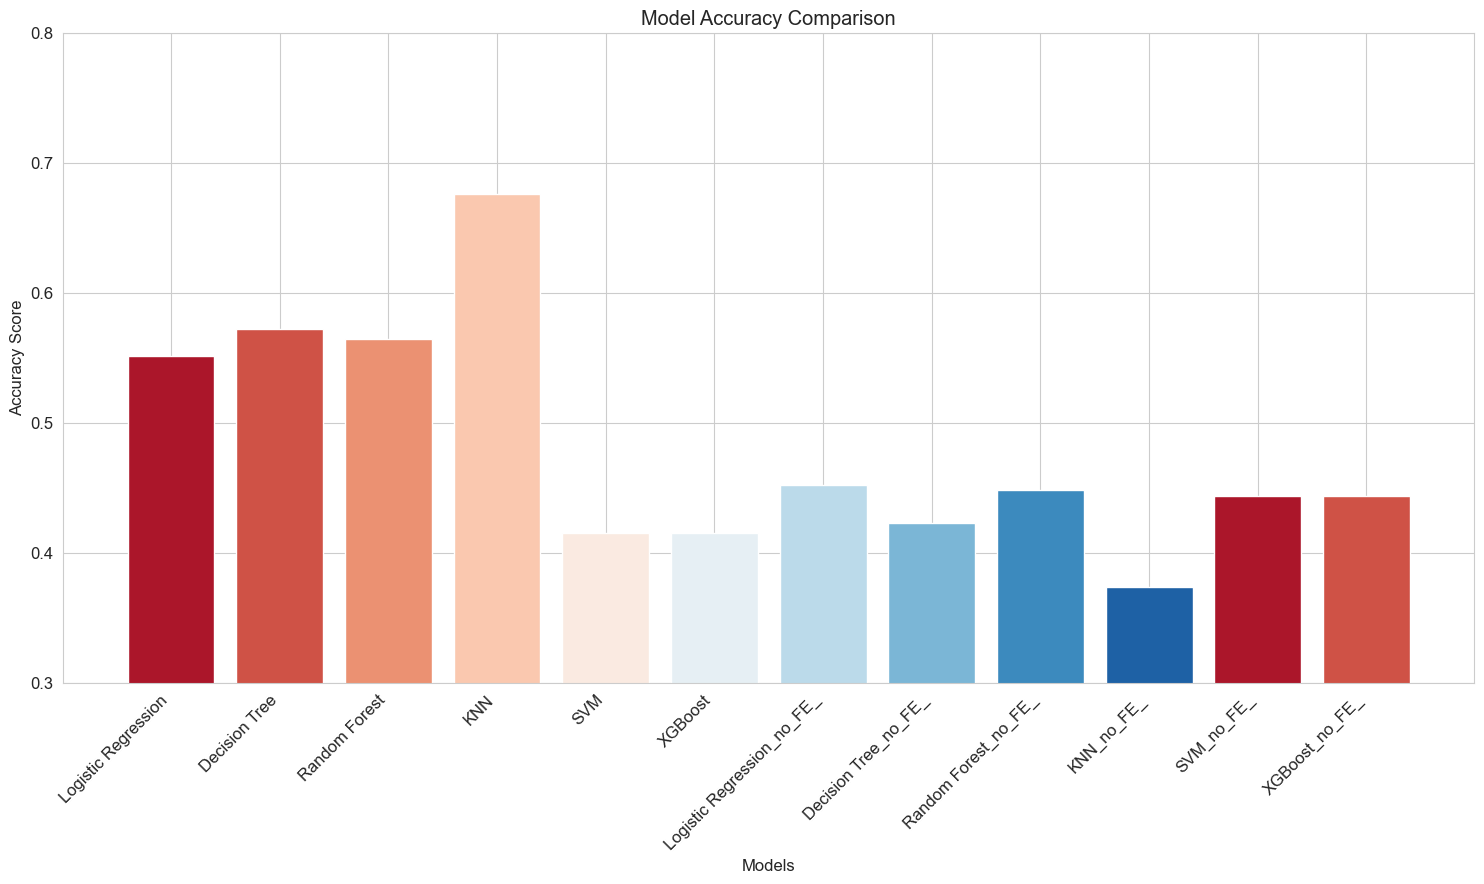

In [398]:
def plot_model_accuracy_comparison(ax, model_names, models, palette=sns.color_palette("RdBu", 10)):
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy Score')
    ax.set_title('Model Accuracy Comparison')
    
    for idx, model_name in enumerate(model_names):
        ax.bar(model_name, models[model_name]['test_accuracy'], color=palette[idx % len(palette)])
    
    ax.set_xticklabels(labels=model_names, rotation=45, ha='right')
    ax.set_ylim([0.3, 0.8])  # Adjusted the ylim for better visualization based on provided data
    plt.tight_layout()

# Testing the modified function with the new color palette
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
plot_model_accuracy_comparison(ax, model_names=all_model_names, models=all_test_scores)
plt.savefig('C:\\Users\\willa\\Downloads\\model_acc.png', dpi=300)
plt.show()


### Trees - Feature Importances

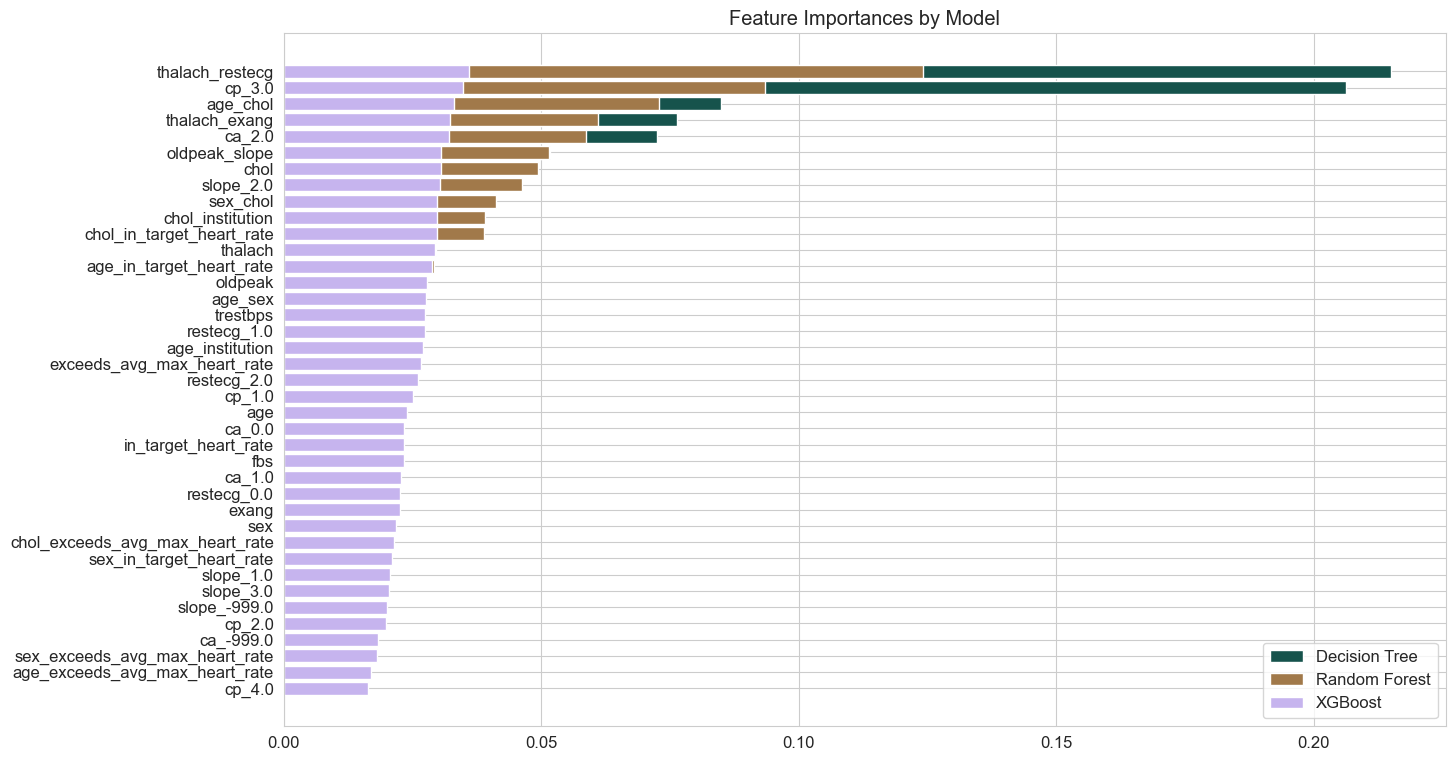

In [403]:
# Visualizing feature importances for tree-based algorithms
def visualize_tree_feature_importances(ax, importances_data, X, cmap=None):
    n_models = len(importances_data)
    colors = sns.color_palette("cubehelix", n_colors=n_models)
    for idx, (name, data) in enumerate(importances_data.items()):
        importances = data['feature_importances']
        indices = np.argsort(importances)
        feature_names = X.columns
        ax.barh(range(len(indices)), importances[indices], align="center", color=colors[idx], label=name)
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.legend(loc="lower right")
    plt.title('Feature Importances by Model')
    plt.savefig('C:\\Users\\willa\\Downloads\\feat_imp.png', dpi=300)
    plt.show()
   

all_feature_importances = feature_importances
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
visualize_tree_feature_importances(ax, all_feature_importances, X_test_preprocessed, cmap=sns.color_palette("cubehelix", as_cmap=True))

### Confusion Matrix

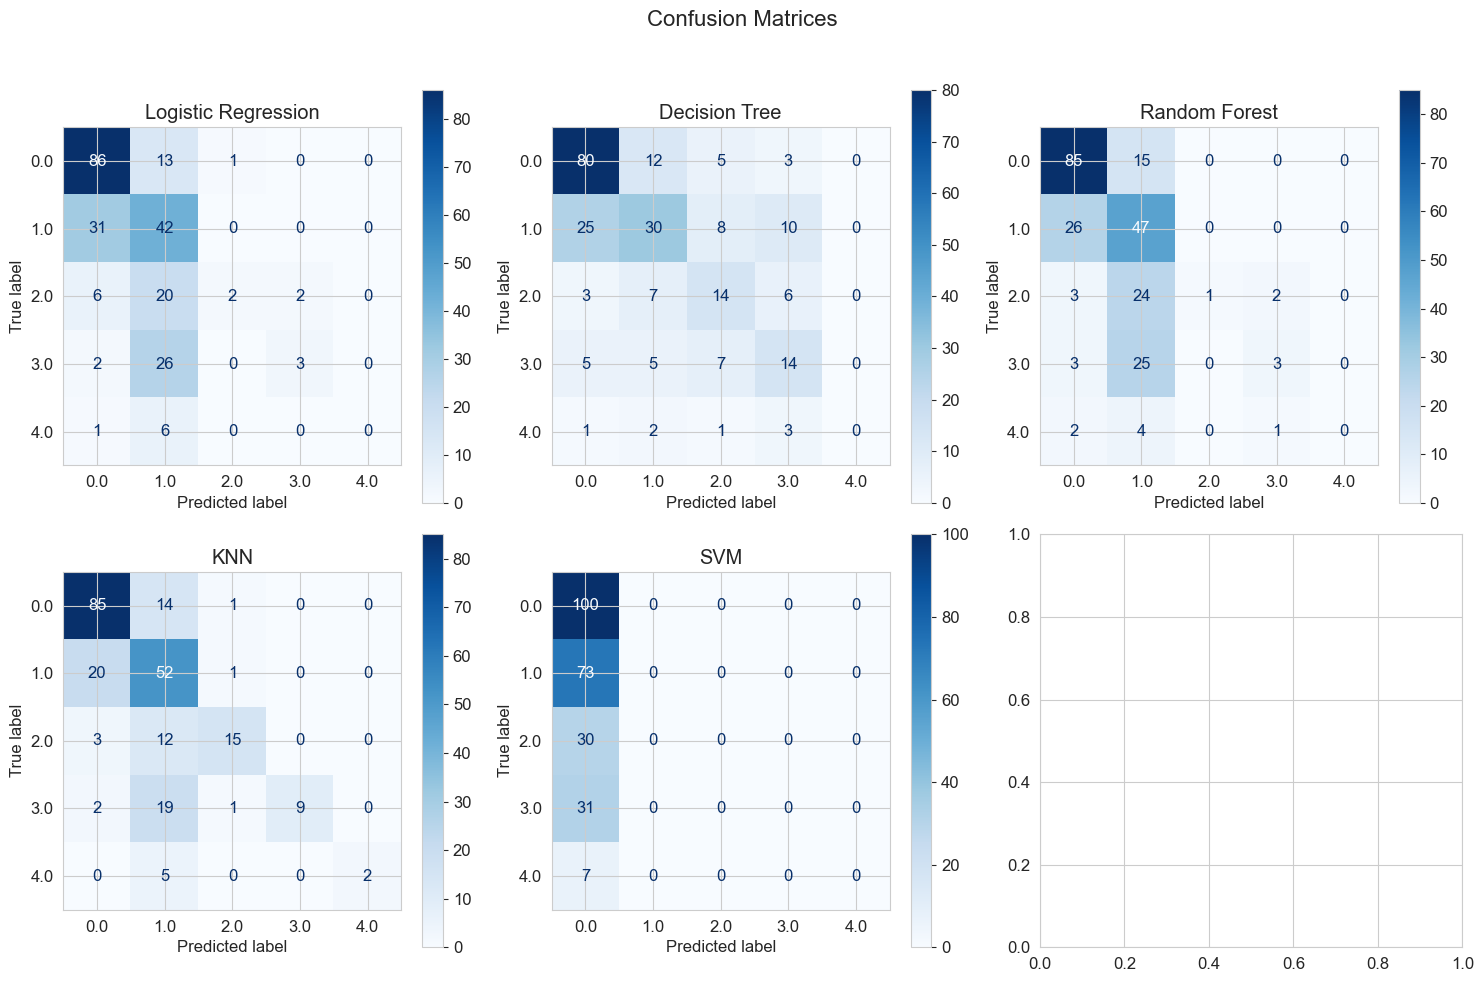

In [401]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

selected_features = load('selected_features.gz')
models_to_evaluate = {
    'Logistic Regression': all_test_scores['Logistic Regression']['model'],
    'Decision Tree': all_test_scores['Decision Tree']['model'],
    'Random Forest': all_test_scores['Random Forest']['model'],
    'KNN': all_test_scores['KNN']['model'],
    'SVM': all_test_scores['SVM']['model'],
    #'XGBoost': all_test_scores['XGBoost']['model']
}

# Define a function to plot confusion matrix on a specific axis
def plot_cm_on_ax(model, X, y, ax, title, cmap='Blues'):
    cm = confusion_matrix(y, model.predict(X))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=cmap, ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Confusion Matrices', fontsize=16)

# Plotting confusion matrices
for ax, (model_name, model) in zip(axes.ravel(), models_to_evaluate.items()):
    if 'XGBoost' in model_name:
        client.cluster.scale(1)
        plot_cm_on_ax(model, dd.from_pandas(X_test_preprocessed[selected_features], npartitions=2).compute(), dd.from_pandas(y_test, npartitions=2).compute(), ax, model_name)
    else:
        client.cluster.scale(12)
        plot_cm_on_ax(model, X_test_preprocessed[selected_features], y_test, ax, model_name)
        
client.cluster.scale(12)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('C:\\Users\\willa\\Downloads\\cms.png', dpi=300)
plt.show()


# Exploratory Data Analysis

## Set Up Data Pull

### Conclusion Notes

**Features and Dataset Analysis**

**Distribution:**

**Continuous Features:**

        - Age: Most participants are in their late 50s to early 60s. This suggests that heart disease studies tend to focus on older individuals since they're at a higher risk.

        - Trestbps: The resting blood pressure of most individuals is in the range of 120 to 140, which is typical for adults.

        - Chol: While most serum cholesterol values are between 200 to 250, the right-skewed distribution indicates the presence of outliers with higher cholesterol levels. This is further supported by the large standard deviation observed for this feature.

        - Thalach: Most individuals have a maximum heart rate between 150-170, indicating the varying fitness levels of participants.

        - Oldpeak: Most values are close to 0, suggesting that ST depression induced by exercise relative to rest is not common among the participants.

**Categorical Features:**

        - Sex: The dataset has a male bias, which could influence model predictions if not accounted for.

        - CP: Type 4 chest pain is most prevalent, indicating that asymptomatic chest pain is common among participants.

        - Restecg: The majority of participants show probable or definite left ventricular hypertrophy by Estes' criteria.

        - Exang: Exercise-induced angina is not commonly observed among participants.

        - Slope, CA, and Thal: These features have significant missing data, which will need careful handling during preprocessing to avoid biasing the model.

**Missing Values:**

        - CA and Thal: High percentages of missing values in these columns suggest that this information was not consistently collected or recorded across institutions. These gaps can be addressed using imputation methods, but caution is needed to avoid introducing bias.
        
        Other features with missing values, such as slope, fbs, and chol, will also need imputation, and their missingness should be explored further to understand if it's missing at random or if there's a systematic reason behind it.


**Dataset Bias:** 

        - The data from the Cleveland institution is overrepresented, which may bias the model and reduce its generalizability.

        - The data from the other institutions also contained many more NaN values - with more time it would be useful to explore different filling/imputation strategies to reduce the effects of NaNs from the non-Cleveland data.


**Feature Importance**: 

    - Features like 'thalach_restecg' (max heat rate * rest heart rate), 'cp_3.0' (high angina rating), and 'age_chol' (age * cholesterol) proved to be highly important in predicting heart disease, according to the feature importance rankings from models like Decisoin Tree, Random Forest and Gradient Boosting.
    
    Several of our nmost important features to these models were engineered/combinant features highlighting demograph-medical or medical-medical interaction.

    - Our models consistently identified age, serum cholesterol levels, heart rate metrics, and certain types of chest pain as strong predictors of heart disease.

**Model Performance**

*Best Model*: 

    - Among the models trained, Model the KNNClassifier demonstrated the best performance, although overall accuracy was lower than expected and may benefit strongly from further processing of the data - especially incorporaton of features present in the larger raw datasets from UCI such as those associated with smoking behaviors.

*Model Limitations*: 

    - While some models performed well, there were limitations in missing data, sparsity of data, and lack of variety in reporting sources. Geographic limitations in our data have us highly biased towards American institutions.

    - Among the models trained, the KNNClassifier, especially after feature engineering, demonstrated superior accuracy. This may suggest that clustering methods may be better suited to our dataset than our ensemble models and we may see improved performance from examining additional clustering methodologies.

    - Additional model types could be examined, such as nerual network classifiers, that may present as better able to identify predictive relationships among the features available.

**Applications/Clinical Implications**

*Predictive Power*: 

    - The best-performing models had moderate predictive power, but examining the confusion matrix shows a tendency to under-predict the severity of heart disease with the KNN model predicting mild heart disease (1) in more than 36 patient records that actually had moderate to severe (2-4) heart disease rankings.

*Feature Insights*: 

    - Some of the most important features are directly related to well-known risk factors for heart disease, such as 'X', reinforcing their clinical relevance.

    - Feature engineering appeared to greatly increase the accuracy, but additonal metrics penalizing under-reporting of disease should be included in the future.

    - The application leaves many avenues for increasing variety and quality of data; features related to lifestyle, genetics, geographic location as well as socioeconomic and cultural-behavioral indicators like field of employment, marital status, diet, smoking, and alcohol consumption could be collected or aggregated from other datasets - the UCI datasets include many interesting features but they are collected poorly with extremely sparsity and varied in the level of reporting by institution.

*Model Tuning*: 

    - Models could be better penalized for the under-reporting of disease and tuned to reduce overfitting.

*Real-world Testing*: 

    - The model should be tested on a more diverse, real-world dataset to validate its effectiveness. The UCI patient record dataset while having many interesting features are lacking in reporting across institutions and seem limited to what a hospital could and likely does have access to in terms of datasets.
